In [1]:
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from tabulate import tabulate
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
nltk.download('vader_lexicon')
import textstat
from lexical_diversity import lex_div as ld
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from collections import Counter
from better_profanity import profanity
from detoxify import Detoxify
# from bertopic import BERTopic
from sklearn.decomposition import LatentDirichletAllocation
import torch

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
c:\Users\User\anaconda3\envs\fyp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Preprocessing function
def preprocessing_old(data_frame):
    ## Preprocessing
    # Removing URLs whithin the tweets
    data_frame["Text"] = data_frame["Text"].str.replace(r'\s*https?://\S+(\s+|$)', ' ', regex=True).str.strip()
    # Removing emails, hashtags and punctuations
    data_frame['Text'] = data_frame["Text"].str.replace(r'\S*@\S*\s?', ' ', regex=True).str.strip()
    data_frame['Text'] = data_frame['Text'].str.replace(r'#\S*\s?', ' ', regex=True).str.strip()
    data_frame['Text'] = data_frame['Text'].str.replace(r'[^\w\s]+', ' ', regex=True).str.strip()

    # Lowercase Text
    data_frame['Text'] = data_frame['Text'].str.lower()

    # # Removing stopwords
    stop = stopwords.words('english')
    data_frame['Text'].apply(lambda x: [item for item in str(x) if item not in stop])

    # Removing newline characters
    data_frame['Text'] = data_frame['Text'].str.rstrip()

    # Tokenizing Posts and counting the length of each post
    data_frame['Tokens'] = data_frame.apply(lambda row: word_tokenize(str(row['Text'])), axis=1)
    data_frame['Length'] = data_frame.apply(lambda row: len(row['Tokens']), axis=1)

    return data_frame

DataLoading

In [3]:
Twitter_path = "twitter-suicidal_data.csv"
df_twitter = pd.read_csv(Twitter_path, encoding='latin-1')
df_twitter = df_twitter.rename(columns={'tweet': 'Text', 'intention': 'Label'})
df_twitter_preprocessed = preprocessing_old(df_twitter.copy())

In [4]:
df_twitter

Text  Label
0     my life is meaningless i just want to end my l...      1
1     muttering i wanna die to myself daily for a fe...      1
2     work slave i really feel like my only purpose ...      1
3     i did something on the 2 of october i overdose...      1
4     i feel like no one cares i just want to die ma...      1
...                                                 ...    ...
9114  have you ever laid on your bed at night and cr...      1
9115  the fault the blame the pain s still there i m...      1
9116  stop asking me to trust you when i m still cou...      1
9117  i never know how to handle sadness crying make...      1
9118  when cancer takes a life we blame cancer depre...      1

[9119 rows x 2 columns]

In [5]:
df_twitter_preprocessed

Text  Label  \
0     my life is meaningless i just want to end my l...      1   
1     muttering i wanna die to myself daily for a fe...      1   
2     work slave i really feel like my only purpose ...      1   
3     i did something on the 2 of october i overdose...      1   
4     i feel like no one cares i just want to die ma...      1   
...                                                 ...    ...   
9114  have you ever laid on your bed at night and cr...      1   
9115  the fault the blame the pain s still there i m...      1   
9116  stop asking me to trust you when i m still cou...      1   
9117  i never know how to handle sadness crying make...      1   
9118  when cancer takes a life we blame cancer depre...      1   

                                                 Tokens  Length  
0     [my, life, is, meaningless, i, just, want, to,...      79  
1     [muttering, i, wan, na, die, to, myself, daily...      46  
2     [work, slave, i, really, feel, like, my, only,...      69  
3     [i, did, something, on, the, 2, of, october, i...      77  
4     [i, feel, like, no, one, cares, i, just, want,...      18  
...                                                 ...     ...  
9114  [have, you, ever, laid, on, your, bed, at, nig...      33  
9115  [the, fault, the, blame, the, pain, s, still, ...      20  
9116  [stop, asking, me, to, trust, you, when, i, m,...      22  
9117  [i, never, know, how, to, handle, sadness, cry...      12  
9118  [when, cancer, takes, a, life, we, blame, canc...      21  

[9119 rows x 4 columns]

In [6]:
Reddit_path = "suicidal_ideation_reddit_annotated.csv"
df_reddit = pd.read_csv(Reddit_path, encoding='latin-1')
df_reddit = df_reddit.rename(columns={'usertext': 'Text', 'label': 'Label'})
df_reddit_preprocessed = preprocessing_old(df_reddit.copy())

In [7]:
df_reddit

Text  Label
0      I just want to end my life so badly. My life i...      1
1      My relationship is complicated and painful, bu...      1
2      I owe a lot of money , so I have to work.The c...      1
3      On the 2 of October I overdosed I just felt so...      1
4      Everyone tells me how wonderful I am, but not ...      1
...                                                  ...    ...
12651  LeVar Burton Reads podcast made me realize how...      0
12652  Irony of Fahrenheit 451 being turned into a mo...      0
12653  Has anyone else ever read Ben Bova's Grand Tou...      0
12654  I've set the date. Only a little while longer....      0
12655  Just wasted $10,000  My professor was going to...      0

[12656 rows x 2 columns]

In [8]:
df_reddit_preprocessed

Text  Label  \
0      i just want to end my life so badly  my life i...      1   
1      my relationship is complicated and painful  bu...      1   
2      i owe a lot of money   so i have to work the c...      1   
3      on the 2 of october i overdosed i just felt so...      1   
4      everyone tells me how wonderful i am  but not ...      1   
...                                                  ...    ...   
12651  levar burton reads podcast made me realize how...      0   
12652  irony of fahrenheit 451 being turned into a mo...      0   
12653  has anyone else ever read ben bova s grand tou...      0   
12654  i ve set the date  only a little while longer ...      0   
12655  just wasted  10 000  my professor was going to...      0   

                                                  Tokens  Length  
0      [i, just, want, to, end, my, life, so, badly, ...      76  
1      [my, relationship, is, complicated, and, painf...     153  
2      [i, owe, a, lot, of, money, so, i, have, to, w...     100  
3      [on, the, 2, of, october, i, overdosed, i, jus...      76  
4      [everyone, tells, me, how, wonderful, i, am, b...      89  
...                                                  ...     ...  
12651  [levar, burton, reads, podcast, made, me, real...      97  
12652  [irony, of, fahrenheit, 451, being, turned, in...     115  
12653  [has, anyone, else, ever, read, ben, bova, s, ...     142  
12654  [i, ve, set, the, date, only, a, little, while...     126  
12655  [just, wasted, 10, 000, my, professor, was, go...     131  

[12656 rows x 4 columns]

In [56]:
def dataset_stats(df):
    """
    Computes a wide range of statistics for a given DataFrame, including
    a breakdown of data quality metrics for each label.
    """
    df = df.copy()
    results = {}

    # --- Process the Whole Dataset and Each Label Slice ---
    slices = {
        'all': df,
        'label_0': df[df['Label'] == 0],
        'label_1': df[df['Label'] == 1]
    }
    
    for name, data_slice in slices.items():
        if data_slice.empty:
            # Add default zero values for empty slices to prevent errors
            for metric in ['null_count', 'duplicate_count', 'empty_string_count', 
                           'whitespace_only_count', 'single_char_count', 'unique_text_count',
                           'avg_words', 'median_words', 'words_25_pct', 'words_75_pct', 'max_words_95',
                           'avg_chars', 'median_chars', 'chars_25_pct', 'chars_75_pct', 'max_chars_95']:
                results[f'{name}_{metric}'] = 0
            continue

        # Create a working copy for this slice
        slice_copy = data_slice.copy()

        # 1. Count nulls BEFORE filling them
        results[f'{name}_null_count'] = slice_copy['Text'].isnull().sum()
        
        # 2. Now, fill nulls for subsequent calculations
        slice_copy['Text'] = slice_copy['Text'].fillna('')
        
        # Calculate word and character counts
        slice_copy['word_count'] = slice_copy['Text'].apply(lambda x: len(word_tokenize(x)))
        slice_copy['char_count'] = slice_copy['Text'].str.len()

        # Calculate data quality metrics
        results[f'{name}_duplicate_count'] = slice_copy.duplicated(subset=['Text']).sum()
        results[f'{name}_empty_string_count'] = (slice_copy['Text'] == '').sum()
        results[f'{name}_whitespace_only_count'] = (slice_copy['Text'].str.strip() == '').sum() - results[f'{name}_empty_string_count']
        results[f'{name}_single_char_count'] = (slice_copy['Text'].str.len() == 1).sum()
        results[f'{name}_unique_text_count'] = slice_copy['Text'].nunique()
        
        # Calculate distribution statistics (Mean, Median, Percentiles)
        results[f'{name}_avg_words'] = slice_copy['word_count'].mean()
        results[f'{name}_words_25_pct'] = slice_copy['word_count'].quantile(0.25)
        results[f'{name}_median_words'] = slice_copy['word_count'].median()
        results[f'{name}_words_75_pct'] = slice_copy['word_count'].quantile(0.75)
        results[f'{name}_max_words_95'] = slice_copy['word_count'].quantile(0.95)
        
        results[f'{name}_avg_chars'] = slice_copy['char_count'].mean()
        results[f'{name}_chars_25_pct'] = slice_copy['char_count'].quantile(0.25)
        results[f'{name}_median_chars'] = slice_copy['char_count'].median()
        results[f'{name}_chars_75_pct'] = slice_copy['char_count'].quantile(0.75)
        results[f'{name}_max_chars_95'] = slice_copy['char_count'].quantile(0.95)

    # --- Add overall stats that don't need slicing ---
    label_counts = df['Label'].value_counts().sort_index()
    results['total'] = len(df)
    results['label_0_total'] = label_counts.get(0, 0)
    results['label_1_total'] = label_counts.get(1, 0)
    results['label_0_pct'] = (results['label_0_total'] / results['total'] * 100) if results['total'] > 0 else 0
    results['label_1_pct'] = (results['label_1_total'] / results['total'] * 100) if results['total'] > 0 else 0
    
    return results

def plot_label_pie(df, name):
    """Plots a pie chart for label distribution."""
    label_counts = df['Label'].value_counts().sort_index()
    labels = [f'Non-Suicidal ({label_counts.get(0, 0)})', f'Suicidal ({label_counts.get(1, 0)})']
    sizes = [label_counts.get(0, 0), label_counts.get(1, 0)]
    colors = ['green', 'red']
    plt.figure(figsize=(5, 5))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
    plt.title(f"{name} - Label Distribution")
    plt.show()

def plot_label_bar(df, name):
    """Plots a bar chart for label distribution."""
    label_counts = df['Label'].value_counts().sort_index()
    plt.figure(figsize=(5, 4))
    ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=['green', 'red'])
    ax.set_xticklabels(['Non-Suicidal (0)', 'Suicidal (1)'])
    plt.ylabel('Count')
    plt.title(f"{name} - Label Distribution")
    plt.show()

def plot_avg_bars(stats_before, stats_after, name):
    """Compares average metrics before and after preprocessing."""
    labels = ['Avg Words/Post', 'Avg Chars/Post']
    before = [stats_before['all_avg_words'], stats_before['all_avg_chars']]
    after = [stats_after['all_avg_words'], stats_after['all_avg_chars']]
    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 5))
    rects1 = ax.bar(x - width/2, before, width, label='Raw', color='skyblue')
    rects2 = ax.bar(x + width/2, after, width, label='Preprocessed', color='orange')
    ax.set_ylabel('Average Count')
    ax.set_title(f"{name} - Avg Words/Chars per Post")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

def plot_length_distributions(df, name):
    """
    Plots the distribution of word and character counts using violin and box plots
    to show percentile information more clearly.
    """
    df = df.copy()
    df['Text'] = df['Text'].fillna('')
    df['word_count'] = df['Text'].apply(lambda x: len(word_tokenize(x)))
    df['char_count'] = df['Text'].str.len()

    plt.figure(figsize=(14, 10))
    plt.suptitle(f'{name} - Post Length Distributions', fontsize=16)

    # --- Word Count Plots ---
    word_upper_limit = df['word_count'].quantile(0.95)

    plt.subplot(2, 2, 1)
    sns.violinplot(data=df, x='Label', y='word_count', palette=['green', 'red'], inner='quartile')
    plt.gca().set_ylim(0, word_upper_limit)
    plt.title('Word Count Distribution by Label')
    plt.xticks([0, 1], ['Non-Suicidal', 'Suicidal'])
    plt.xlabel('Label')
    plt.ylabel('Word Count')

    plt.subplot(2, 2, 2)
    sns.boxplot(data=df, x='Label', y='word_count', palette=['green', 'red'])
    plt.gca().set_ylim(0, word_upper_limit)
    plt.title('Word Count Percentiles by Label')
    plt.xticks([0, 1], ['Non-Suicidal', 'Suicidal'])
    plt.xlabel('Label')
    plt.ylabel('Word Count')

    # --- Character Count Plots ---
    char_upper_limit = df['char_count'].quantile(0.95)

    plt.subplot(2, 2, 3)
    sns.violinplot(data=df, x='Label', y='char_count', palette=['green', 'red'], inner='quartile')
    plt.gca().set_ylim(0, char_upper_limit)
    plt.title('Character Count Distribution by Label')
    plt.xticks([0, 1], ['Non-Suicidal', 'Suicidal'])
    plt.xlabel('Label')
    plt.ylabel('Character Count')

    plt.subplot(2, 2, 4)
    sns.boxplot(data=df, x='Label', y='char_count', palette=['green', 'red'])
    plt.gca().set_ylim(0, char_upper_limit)
    plt.title('Character Count Percentiles by Label')
    plt.xticks([0, 1], ['Non-Suicidal', 'Suicidal'])
    plt.xlabel('Label')
    plt.ylabel('Character Count')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_word_count_distribution(df, name):
    """Plots the distribution of word counts for the dataset and by label."""
    df = df.copy()
    df['Text'] = df['Text'].fillna('')
    df['word_count'] = df['Text'].apply(lambda x: len(word_tokenize(x)))

    plt.figure(figsize=(12, 5))
    plt.suptitle(f'{name} - Word Count Distribution per Post', fontsize=16)

    # Plot 1: Comparison by Label
    plt.subplot(1, 2, 1)
    upper_limit = df['word_count'].quantile(0.95) # Use 95th percentile to handle outliers
    sns.kdeplot(data=df, x='word_count', hue='Label', palette=['green', 'red'], fill=True, clip=(0, upper_limit))
    plt.title('Comparison by Label')
    plt.xlabel('Word Count')
    plt.ylabel('Density')

    # Plot 2: Whole Dataset
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x='word_count', color='purple', fill=True, clip=(0, upper_limit))
    plt.title('Overall Distribution')
    plt.xlabel('Word Count')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def overview_and_compare(df_raw, df_pre, name):
    """Generates a full comparison report with a detailed label breakdown."""
    print(f"--- Generating Overview for {name} ---")
    stats_raw = dataset_stats(df_raw)
    stats_pre = dataset_stats(df_pre)
    
    # --- Plotting Section ---
    plot_label_pie(df_raw, f"{name} (Raw)")
    plot_label_bar(df_pre, f"{name} (Preprocessed)")
    plot_avg_bars(stats_raw, stats_pre, name)
    plot_word_count_distribution(df_raw, f"{name} (Raw)")
    plot_word_count_distribution(df_pre, f"{name} (Preprocessed)")
    plot_length_distributions(df_raw, f"{name} (Raw)") 
    plot_length_distributions(df_pre, f"{name} (Preprocessed)") 
    # --- Summary Table Section ---
    table = [
        ['Metric', 'Raw', 'Preprocessed'],
        ['Total Posts', stats_raw['total'], stats_pre['total']],
        ['  - Non-Suicidal (0)', f"{stats_raw['label_0_total']} ({stats_raw['label_0_pct']:.1f}%)", f"{stats_pre['label_0_total']} ({stats_pre['label_0_pct']:.1f}%)"],
        ['  - Suicidal (1)', f"{stats_raw['label_1_total']} ({stats_raw['label_1_pct']:.1f}%)", f"{stats_pre['label_1_total']} ({stats_pre['label_1_pct']:.1f}%)"],
    ]
    
    metrics_to_breakdown = {
        'avg_words': 'Avg Words/Post', 'median_words': 'Median Words (50th %ile)', 
        'words_25_pct': 'Words (25th %ile)', 'words_75_pct': 'Words (75th %ile)', 'max_words_95': 'Max Words (95th %ile)',
        'avg_chars': 'Avg Chars/Post', 'median_chars': 'Median Chars (50th %ile)',
        'chars_25_pct': 'Chars (25th %ile)', 'chars_75_pct': 'Chars (75th %ile)', 'max_chars_95': 'Max Chars (95th %ile)',
        'null_count': 'Null Values', 'duplicate_count': 'Duplicate Posts',
        'empty_string_count': 'Empty Strings ("")', 'whitespace_only_count': 'Whitespace Only',
        'single_char_count': 'Single Character Posts', 'unique_text_count': 'Unique Text Posts'
    }
    
    for key, metric_name in metrics_to_breakdown.items():
        table.append(['-' * (len(metric_name) + 8), '------------', '--------------'])
        is_float = any(x in key for x in ['avg', 'median', 'pct', 'max'])
        
        for slice_key, slice_name in [('all', ' (Total)'), ('label_0', '  - Label 0'), ('label_1', '  - Label 1')]:
            raw_val = f"{stats_raw[f'{slice_key}_{key}']:.1f}" if is_float else stats_raw[f'{slice_key}_{key}']
            pre_val = f"{stats_pre[f'{slice_key}_{key}']:.1f}" if is_float else stats_pre[f'{slice_key}_{key}']
            table.append([f'{metric_name}{slice_name}', raw_val, pre_val])

    print(f"\n--- Comparison Summary for {name} ---")
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

def show_special_cases(df, name):
    """Displays examples of special case rows."""
    df = df.copy()
    df['Text'] = df['Text'].fillna('')
    print(f"\n--- Special Case Examples for {name} ---")
    
    cases = {
        "Empty strings": df[df['Text'] == ''],
        "Whitespace only": df[(df['Text'].str.strip() == '') & (df['Text'] != '')],
        "Single character": df[df['Text'].str.len() == 1]
    }
    
    for case_name, case_df in cases.items():
        if not case_df.empty:
            print(f"\n{case_name}: {len(case_df)} found")
            print(tabulate(case_df[['Text', 'Label']].head(3), headers='keys', tablefmt='fancy_grid'))
        else:
            print(f"\n{case_name}: 0 found")
def detailed_dtype_summary(df, name):
    print(f"\n{name} - Detailed DataType Summary:")
    dtype_table = []
    for col in df.columns:
        # Skip the Tokens column
        if col == 'Tokens':
            continue
            
        # Handle different data types
        if df[col].dtype == 'object':
            # Check if it's a list column
            if df[col].apply(lambda x: isinstance(x, list)).any():
                unique_count = f"Lists (avg len: {df[col].apply(lambda x: len(x) if isinstance(x, list) else 0).mean():.1f})"
            else:
                try:
                    unique_count = df[col].nunique()
                except TypeError:
                    unique_count = "N/A (unhashable)"
        else:
            unique_count = df[col].nunique()
        
        dtype_table.append([
            col,
            str(df[col].dtype),
            df[col].isnull().sum(),
            unique_count,
            df[col].dtype.kind if hasattr(df[col].dtype, 'kind') else 'N/A'
        ])
    print(tabulate(dtype_table, headers=['Column', 'DataType', 'Null Count', 'Unique Count', 'Kind'], tablefmt='fancy_grid'))

--- Generating Overview for Twitter ---


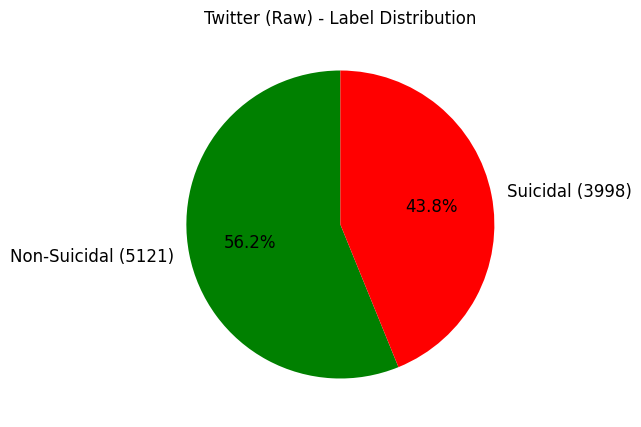

C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=['green', 'red'])
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Non-Suicidal (0)', 'Suicidal (1)'])


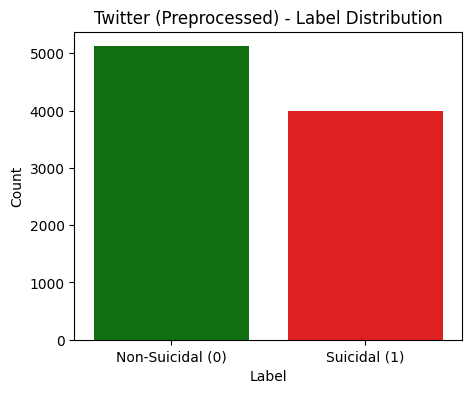

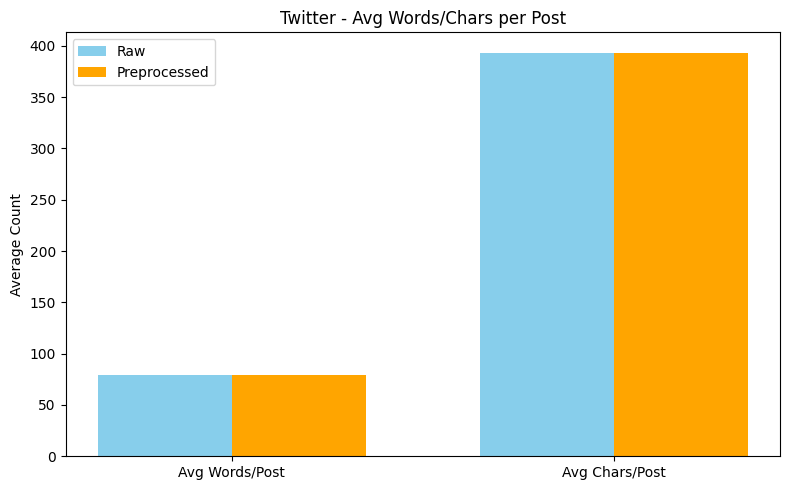

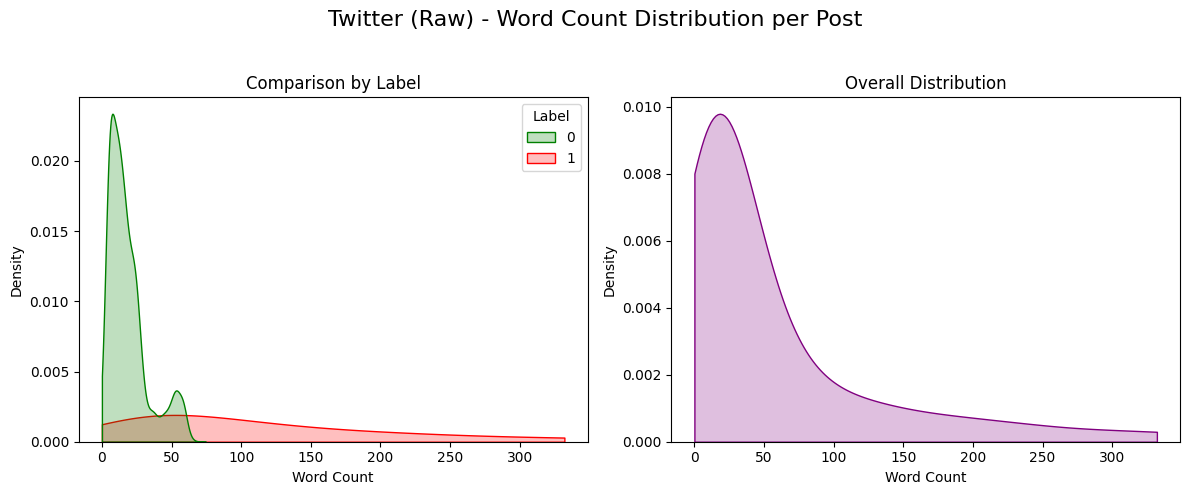

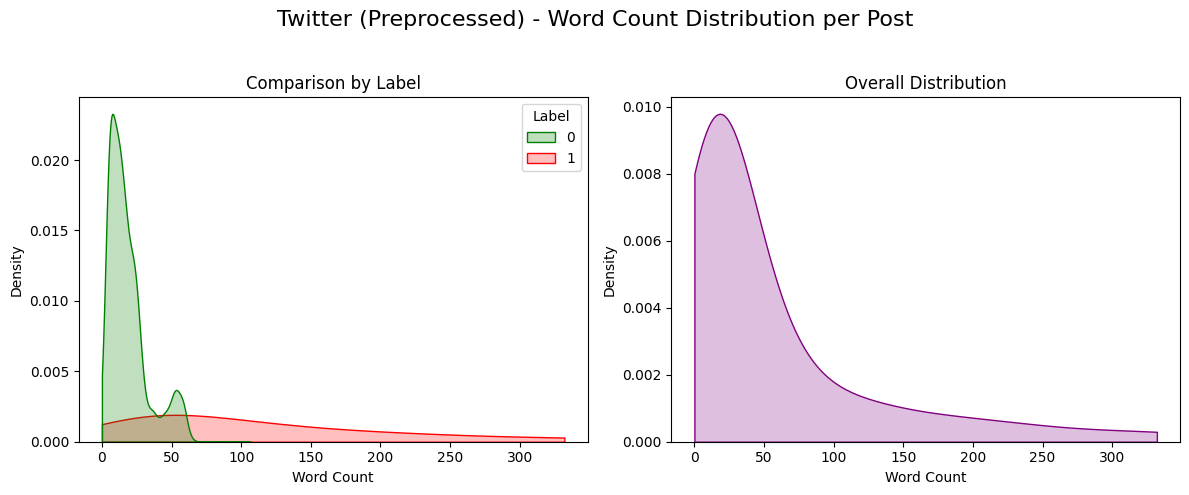

C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Label', y='word_count', palette=['green', 'red'], inner='quartile')
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Label', y='word_count', palette=['green', 'red'])
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Label', y='char_count', palette=['green', 're

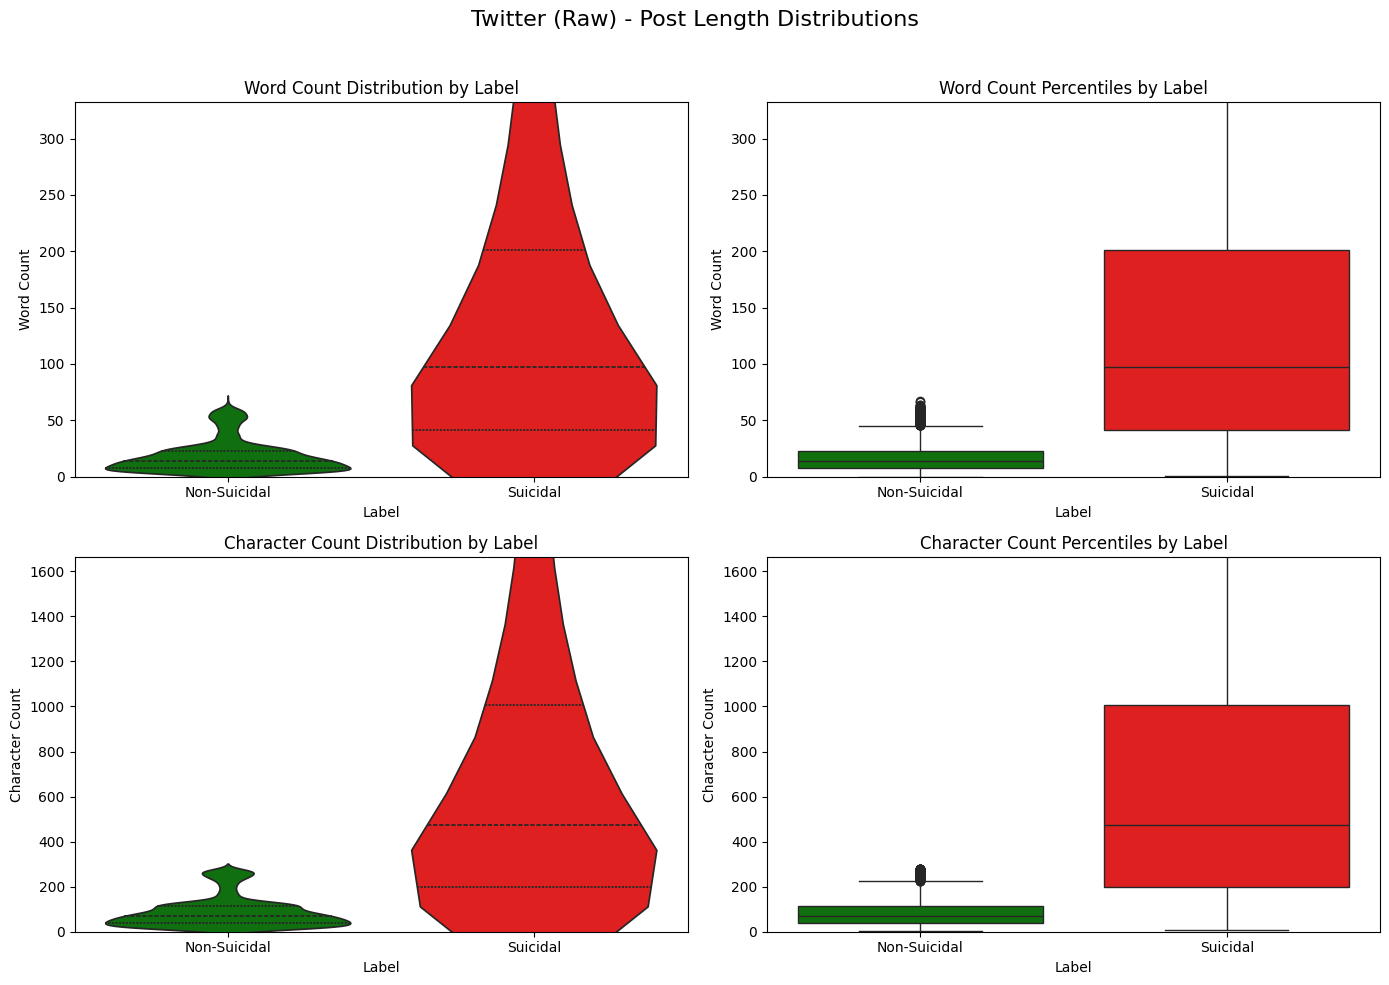

C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Label', y='word_count', palette=['green', 'red'], inner='quartile')
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Label', y='word_count', palette=['green', 'red'])
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Label', y='char_count', palette=['green', 're

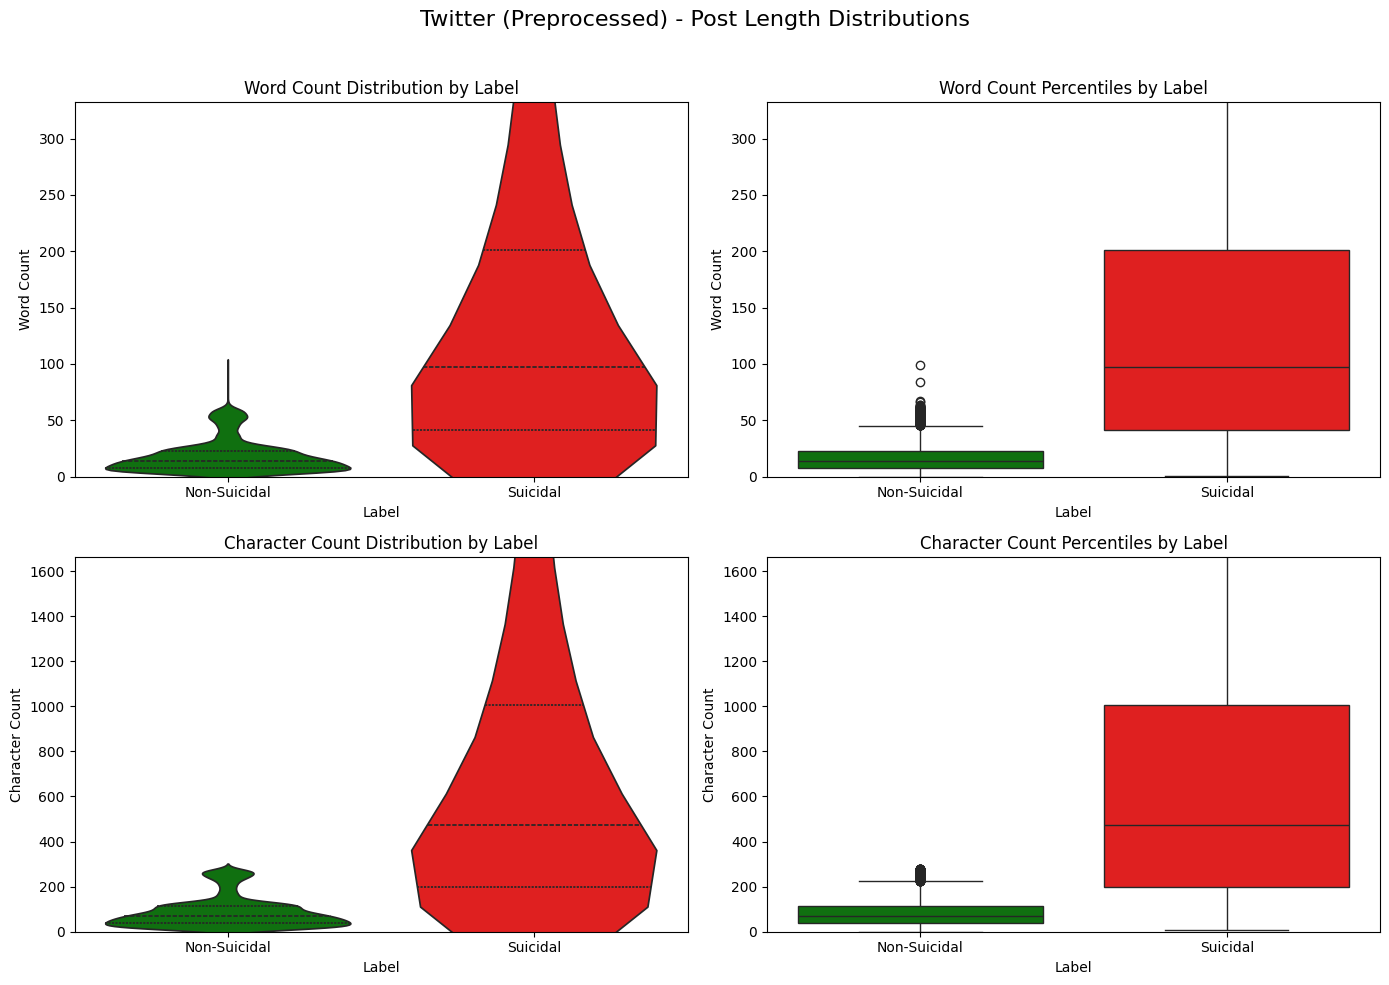


--- Comparison Summary for Twitter ---
╒═════════════════════════════════════╤══════════════╤════════════════╕
│ Metric                              │ Raw          │ Preprocessed   │
╞═════════════════════════════════════╪══════════════╪════════════════╡
│ Total Posts                         │ 9119         │ 9119           │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ - Non-Suicidal (0)                  │ 5121 (56.2%) │ 5121 (56.2%)   │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ - Suicidal (1)                      │ 3998 (43.8%) │ 3998 (43.8%)   │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ ----------------------              │ ------------ │ -------------- │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ Avg Words/Post (Total)              │ 79.5         │ 79.5           │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ Avg Words/Post  - Labe

In [57]:
overview_and_compare(df_twitter, df_twitter_preprocessed, "Twitter")

--- Generating Overview for Reddit ---


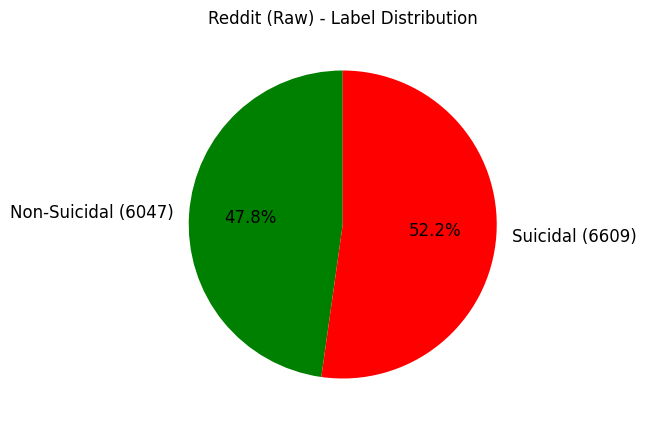

C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=['green', 'red'])
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:85: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Non-Suicidal (0)', 'Suicidal (1)'])


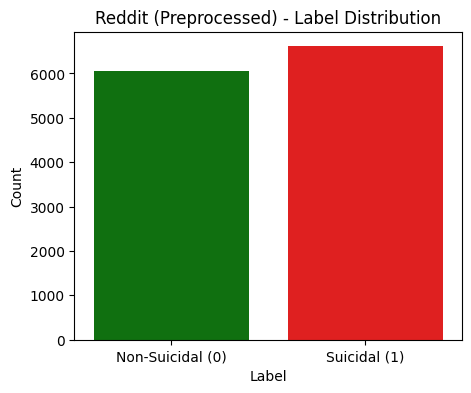

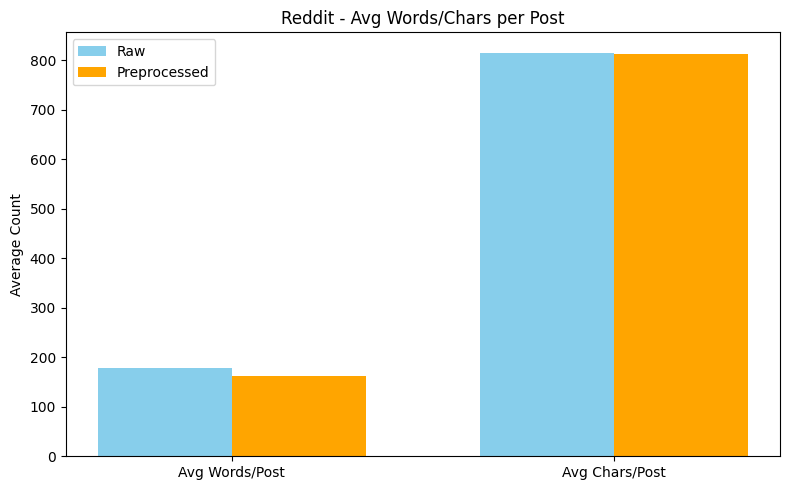

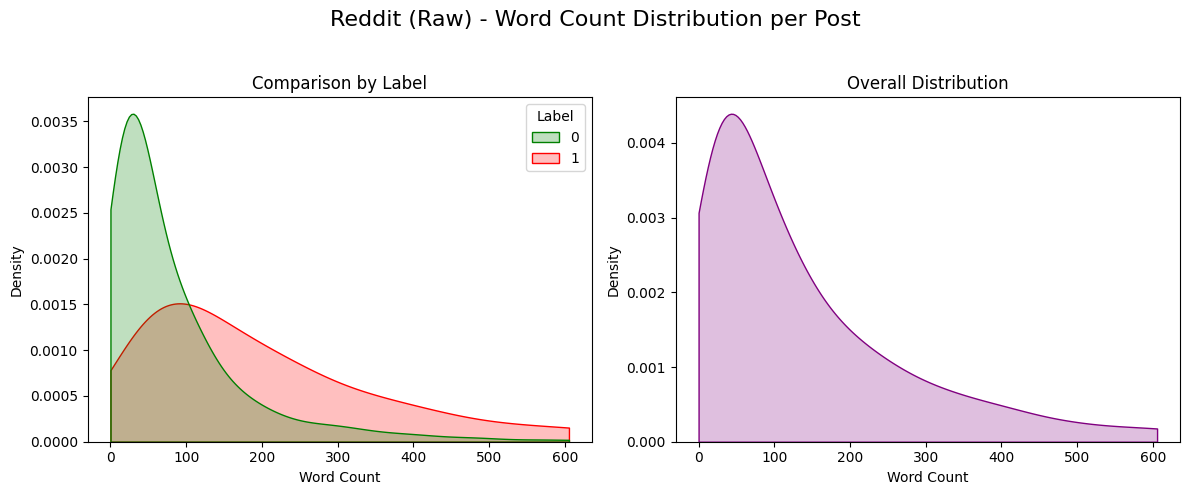

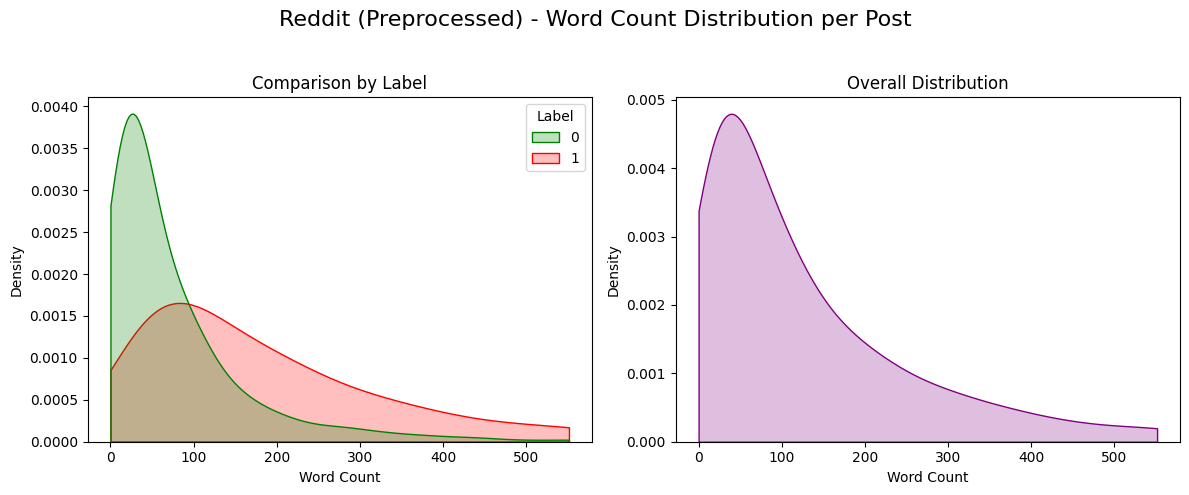

C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Label', y='word_count', palette=['green', 'red'], inner='quartile')
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Label', y='word_count', palette=['green', 'red'])
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Label', y='char_count', palette=['green', 're

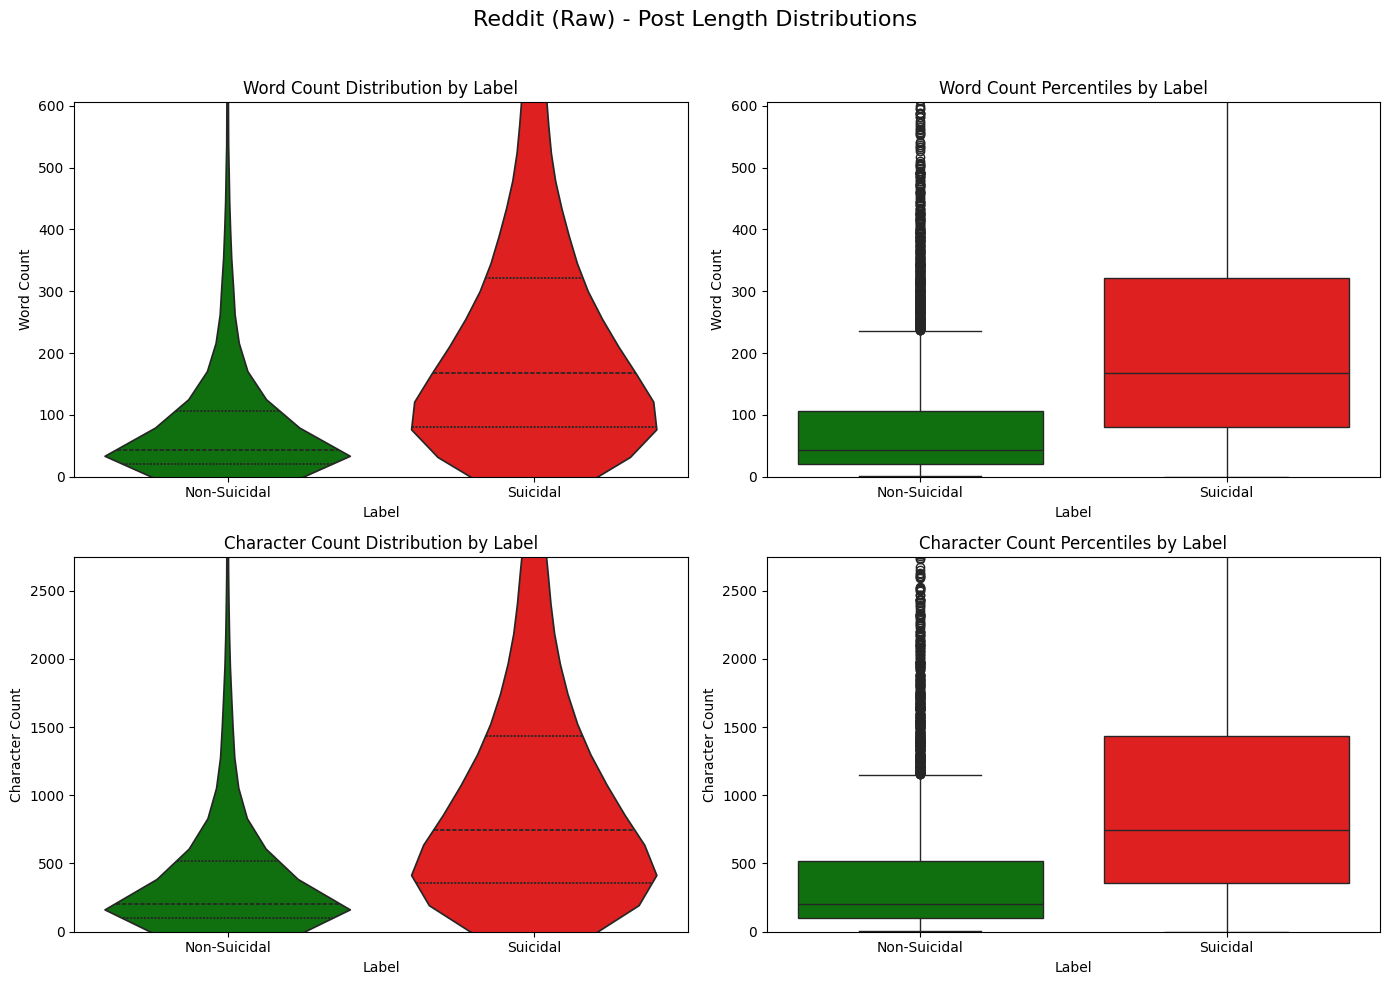

C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Label', y='word_count', palette=['green', 'red'], inner='quartile')
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Label', y='word_count', palette=['green', 'red'])
C:\Users\User\AppData\Local\Temp\ipykernel_12740\1606444566.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Label', y='char_count', palette=['green', 're

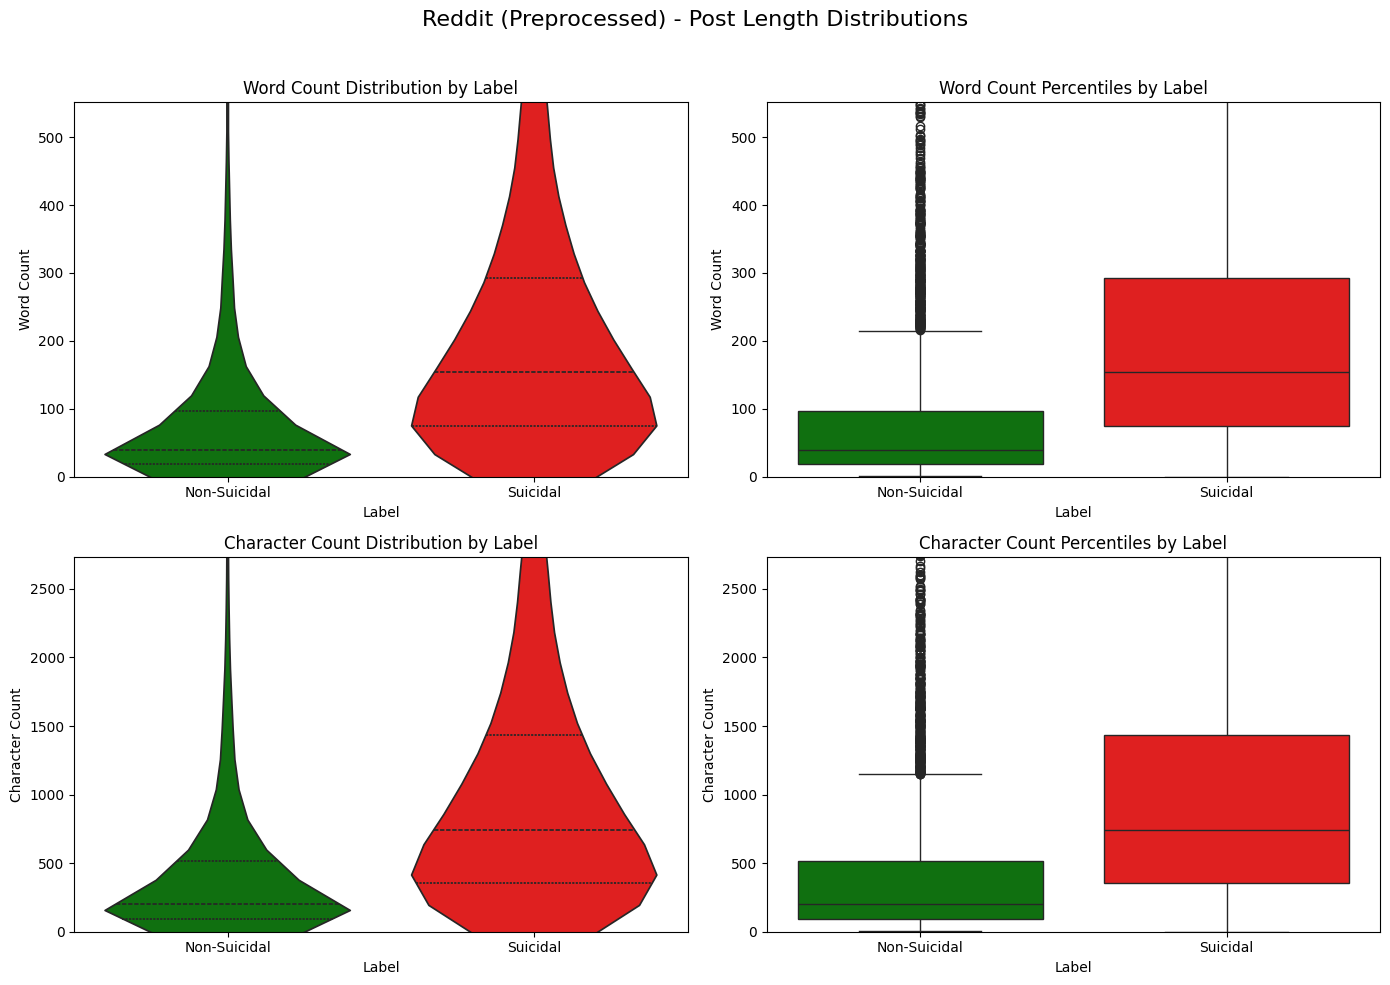


--- Comparison Summary for Reddit ---
╒═════════════════════════════════════╤══════════════╤════════════════╕
│ Metric                              │ Raw          │ Preprocessed   │
╞═════════════════════════════════════╪══════════════╪════════════════╡
│ Total Posts                         │ 12656        │ 12656          │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ - Non-Suicidal (0)                  │ 6047 (47.8%) │ 6047 (47.8%)   │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ - Suicidal (1)                      │ 6609 (52.2%) │ 6609 (52.2%)   │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ ----------------------              │ ------------ │ -------------- │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ Avg Words/Post (Total)              │ 178.1        │ 162.7          │
├─────────────────────────────────────┼──────────────┼────────────────┤
│ Avg Words/Post  - Label

In [58]:
overview_and_compare(df_reddit, df_reddit_preprocessed, "Reddit")

In [38]:
show_special_cases(df_reddit, "Reddit (Raw)")
show_special_cases(df_twitter, "Twitter (Raw)")


--- Special Case Examples for Reddit (Raw) ---

Empty strings: 41 found
╒════╤════════╤═════════╕
│    │ Text   │   Label │
╞════╪════════╪═════════╡
│ 23 │        │       1 │
├────┼────────┼─────────┤
│ 46 │        │       1 │
├────┼────────┼─────────┤
│ 99 │        │       1 │
╘════╧════════╧═════════╛

Whitespace only: 1 found
╒══════╤════════╤═════════╕
│      │ Text   │   Label │
╞══════╪════════╪═════════╡
│ 1050 │        │       1 │
╘══════╧════════╧═════════╛

Single character: 3 found
╒══════╤════════╤═════════╕
│      │ Text   │   Label │
╞══════╪════════╪═════════╡
│  986 │ .      │       1 │
├──────┼────────┼─────────┤
│ 1050 │        │       1 │
├──────┼────────┼─────────┤
│ 2113 │ .      │       1 │
╘══════╧════════╧═════════╛

--- Special Case Examples for Twitter (Raw) ---

Empty strings: 0 found

Whitespace only: 10 found
╒══════╤════════╤═════════╕
│      │ Text   │   Label │
╞══════╪════════╪═════════╡
│ 3401 │        │       0 │
├──────┼────────┼─────────┤
│ 3924 │

In [39]:
show_special_cases(df_reddit_preprocessed, "Reddit (Preprocessed)")
show_special_cases(df_twitter_preprocessed, "Twitter (Preprocessed)")


--- Special Case Examples for Reddit (Preprocessed) ---

Empty strings: 44 found
╒════╤════════╤═════════╕
│    │ Text   │   Label │
╞════╪════════╪═════════╡
│ 23 │        │       1 │
├────┼────────┼─────────┤
│ 46 │        │       1 │
├────┼────────┼─────────┤
│ 99 │        │       1 │
╘════╧════════╧═════════╛

Whitespace only: 0 found

Single character: 0 found

--- Special Case Examples for Twitter (Preprocessed) ---

Empty strings: 10 found
╒══════╤════════╤═════════╕
│      │ Text   │   Label │
╞══════╪════════╪═════════╡
│ 3401 │        │       0 │
├──────┼────────┼─────────┤
│ 3924 │        │       0 │
├──────┼────────┼─────────┤
│ 4304 │        │       0 │
╘══════╧════════╧═════════╛

Whitespace only: 0 found

Single character: 1 found
╒══════╤════════╤═════════╕
│      │ Text   │   Label │
╞══════╪════════╪═════════╡
│ 8004 │ l      │       0 │
╘══════╧════════╧═════════╛


In [14]:
detailed_dtype_summary(df_reddit, "Reddit (Raw)")
detailed_dtype_summary(df_twitter, "Twitter (Raw)")


Reddit (Raw) - Detailed DataType Summary:
╒══════════╤════════════╤══════════════╤════════════════╤════════╕
│ Column   │ DataType   │   Null Count │   Unique Count │ Kind   │
╞══════════╪════════════╪══════════════╪════════════════╪════════╡
│ Text     │ object     │           41 │          12387 │ O      │
├──────────┼────────────┼──────────────┼────────────────┼────────┤
│ Label    │ int64      │            0 │              2 │ i      │
╘══════════╧════════════╧══════════════╧════════════════╧════════╛

Twitter (Raw) - Detailed DataType Summary:
╒══════════╤════════════╤══════════════╤════════════════╤════════╕
│ Column   │ DataType   │   Null Count │   Unique Count │ Kind   │
╞══════════╪════════════╪══════════════╪════════════════╪════════╡
│ Text     │ object     │            0 │           8785 │ O      │
├──────────┼────────────┼──────────────┼────────────────┼────────┤
│ Label    │ int64      │            0 │              2 │ i      │
╘══════════╧════════════╧══════════════╧══

In [15]:
detailed_dtype_summary(df_twitter_preprocessed, "Twitter (Processed)")
detailed_dtype_summary(df_reddit_preprocessed, "Reddit (Processed)")


Twitter (Processed) - Detailed DataType Summary:
╒══════════╤════════════╤══════════════╤════════════════╤════════╕
│ Column   │ DataType   │   Null Count │   Unique Count │ Kind   │
╞══════════╪════════════╪══════════════╪════════════════╪════════╡
│ Text     │ object     │            0 │           8758 │ O      │
├──────────┼────────────┼──────────────┼────────────────┼────────┤
│ Label    │ int64      │            0 │              2 │ i      │
├──────────┼────────────┼──────────────┼────────────────┼────────┤
│ Length   │ int64      │            0 │            621 │ i      │
╘══════════╧════════════╧══════════════╧════════════════╧════════╛

Reddit (Processed) - Detailed DataType Summary:
╒══════════╤════════════╤══════════════╤════════════════╤════════╕
│ Column   │ DataType   │   Null Count │   Unique Count │ Kind   │
╞══════════╪════════════╪══════════════╪════════════════╪════════╡
│ Text     │ object     │           41 │          12384 │ O      │
├──────────┼────────────┼─────


Twitter (Raw) - Label 0 (Top Unigrams):
╒═══════════╤═════════╕
│ Unigram   │   Count │
╞═══════════╪═════════╡
│ want      │    1170 │
├───────────┼─────────┤
│ die       │     942 │
├───────────┼─────────┤
│ just      │     661 │
├───────────┼─────────┤
│ hate      │     566 │
├───────────┼─────────┤
│ like      │     507 │
├───────────┼─────────┤
│ feel      │     420 │
├───────────┼─────────┤
│ don       │     414 │
├───────────┼─────────┤
│ kill      │     378 │
├───────────┼─────────┤
│ work      │     288 │
├───────────┼─────────┤
│ dont      │     271 │
├───────────┼─────────┤
│ know      │     263 │
├───────────┼─────────┤
│ day       │     244 │
├───────────┼─────────┤
│ going     │     243 │
├───────────┼─────────┤
│ really    │     209 │
├───────────┼─────────┤
│ people    │     207 │
├───────────┼─────────┤
│ got       │     201 │
├───────────┼─────────┤
│ today     │     188 │
├───────────┼─────────┤
│ good      │     183 │
├───────────┼─────────┤
│ time      │     177 │

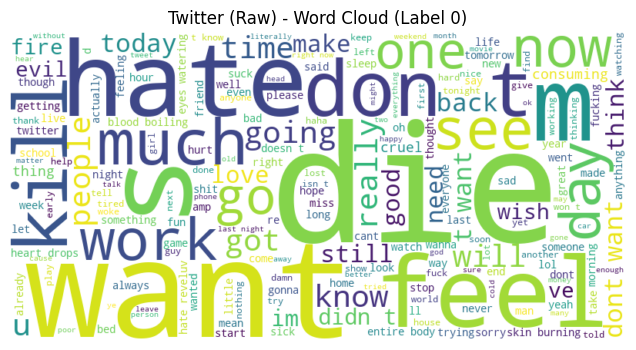


Twitter (Raw) - Label 1 (Top Unigrams):
╒═══════════╤═════════╕
│ Unigram   │   Count │
╞═══════════╪═════════╡
│ just      │    5281 │
├───────────┼─────────┤
│ dont      │    4321 │
├───────────┼─────────┤
│ want      │    3840 │
├───────────┼─────────┤
│ like      │    3291 │
├───────────┼─────────┤
│ feel      │    3056 │
├───────────┼─────────┤
│ life      │    3029 │
├───────────┼─────────┤
│ know      │    2863 │
├───────────┼─────────┤
│ ive       │    2222 │
├───────────┼─────────┤
│ time      │    1799 │
├───────────┼─────────┤
│ people    │    1798 │
├───────────┼─────────┤
│ really    │    1726 │
├───────────┼─────────┤
│ going     │    1590 │
├───────────┼─────────┤
│ think     │    1445 │
├───────────┼─────────┤
│ friends   │    1442 │
├───────────┼─────────┤
│ years     │    1264 │
├───────────┼─────────┤
│ help      │    1225 │
├───────────┼─────────┤
│ die       │    1202 │
├───────────┼─────────┤
│ anymore   │    1189 │
├───────────┼─────────┤
│ kill      │    1107 │

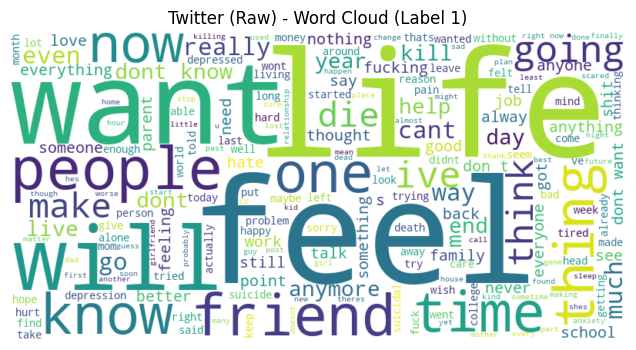

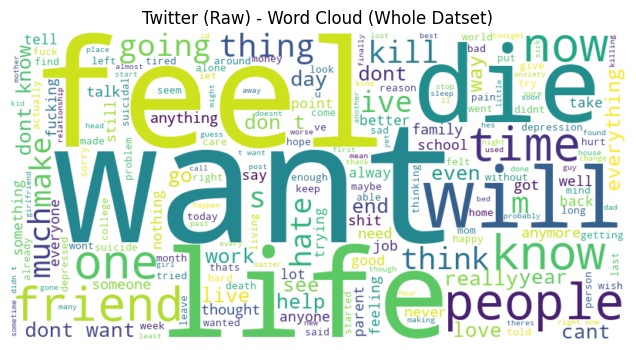


Twitter (Preprocessed) - Label 0 (Top Unigrams):
╒═══════════╤═════════╕
│ Unigram   │   Count │
╞═══════════╪═════════╡
│ want      │    1170 │
├───────────┼─────────┤
│ die       │     942 │
├───────────┼─────────┤
│ just      │     661 │
├───────────┼─────────┤
│ hate      │     566 │
├───────────┼─────────┤
│ like      │     507 │
├───────────┼─────────┤
│ feel      │     420 │
├───────────┼─────────┤
│ don       │     414 │
├───────────┼─────────┤
│ kill      │     378 │
├───────────┼─────────┤
│ work      │     288 │
├───────────┼─────────┤
│ dont      │     271 │
├───────────┼─────────┤
│ know      │     263 │
├───────────┼─────────┤
│ day       │     244 │
├───────────┼─────────┤
│ going     │     243 │
├───────────┼─────────┤
│ really    │     209 │
├───────────┼─────────┤
│ people    │     207 │
├───────────┼─────────┤
│ got       │     201 │
├───────────┼─────────┤
│ today     │     188 │
├───────────┼─────────┤
│ good      │     183 │
├───────────┼─────────┤
│ time      │ 

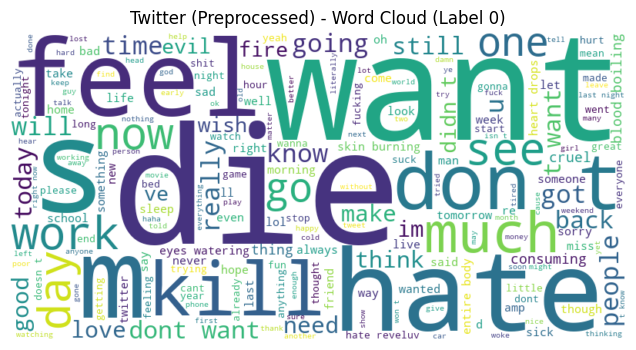


Twitter (Preprocessed) - Label 1 (Top Unigrams):
╒═══════════╤═════════╕
│ Unigram   │   Count │
╞═══════════╪═════════╡
│ just      │    5281 │
├───────────┼─────────┤
│ dont      │    4321 │
├───────────┼─────────┤
│ want      │    3840 │
├───────────┼─────────┤
│ like      │    3291 │
├───────────┼─────────┤
│ feel      │    3056 │
├───────────┼─────────┤
│ life      │    3029 │
├───────────┼─────────┤
│ know      │    2863 │
├───────────┼─────────┤
│ ive       │    2222 │
├───────────┼─────────┤
│ time      │    1799 │
├───────────┼─────────┤
│ people    │    1798 │
├───────────┼─────────┤
│ really    │    1726 │
├───────────┼─────────┤
│ going     │    1590 │
├───────────┼─────────┤
│ think     │    1445 │
├───────────┼─────────┤
│ friends   │    1442 │
├───────────┼─────────┤
│ years     │    1264 │
├───────────┼─────────┤
│ help      │    1225 │
├───────────┼─────────┤
│ die       │    1202 │
├───────────┼─────────┤
│ anymore   │    1189 │
├───────────┼─────────┤
│ kill      │ 

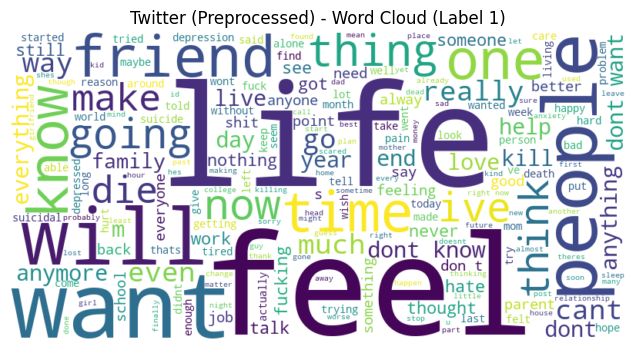

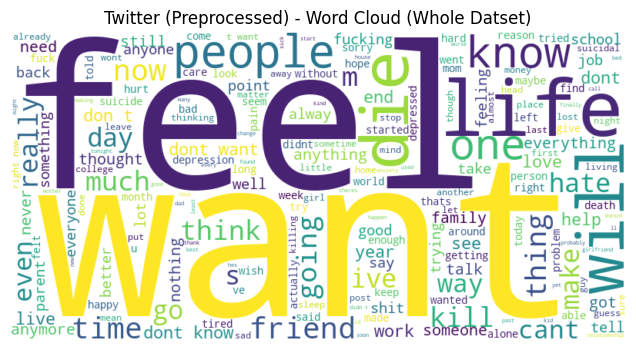


Reddit (Raw) - Label 0 (Top Unigrams):
╒═══════════╤═════════╕
│ Unigram   │   Count │
╞═══════════╪═════════╡
│ just      │    2788 │
├───────────┼─────────┤
│ like      │    2236 │
├───────────┼─────────┤
│ book      │    1854 │
├───────────┼─────────┤
│ read      │    1560 │
├───────────┼─────────┤
│ ve        │    1470 │
├───────────┼─────────┤
│ don       │    1452 │
├───────────┼─────────┤
│ time      │    1351 │
├───────────┼─────────┤
│ know      │    1298 │
├───────────┼─────────┤
│ people    │    1213 │
├───────────┼─────────┤
│ books     │    1140 │
├───────────┼─────────┤
│ life      │    1069 │
├───────────┼─────────┤
│ really    │    1058 │
├───────────┼─────────┤
│ want      │    1030 │
├───────────┼─────────┤
│ think     │    1025 │
├───────────┼─────────┤
│ feel      │     972 │
├───────────┼─────────┤
│ reading   │     942 │
├───────────┼─────────┤
│ way       │     793 │
├───────────┼─────────┤
│ good      │     772 │
├───────────┼─────────┤
│ did       │     722 │


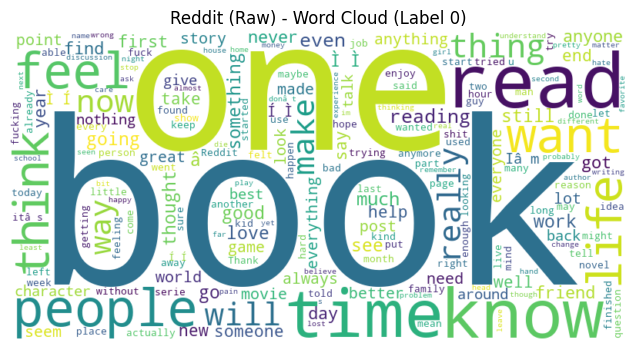


Reddit (Raw) - Label 1 (Top Unigrams):
╒═══════════╤═════════╕
│ Unigram   │   Count │
╞═══════════╪═════════╡
│ just      │   12199 │
├───────────┼─────────┤
│ don       │    9039 │
├───────────┼─────────┤
│ like      │    7957 │
├───────────┼─────────┤
│ want      │    7777 │
├───────────┼─────────┤
│ life      │    6998 │
├───────────┼─────────┤
│ feel      │    6573 │
├───────────┼─────────┤
│ ve        │    6449 │
├───────────┼─────────┤
│ know      │    6399 │
├───────────┼─────────┤
│ time      │    4556 │
├───────────┼─────────┤
│ people    │    4417 │
├───────────┼─────────┤
│ really    │    4005 │
├───────────┼─────────┤
│ going     │    3555 │
├───────────┼─────────┤
│ think     │    3479 │
├───────────┼─────────┤
│ friends   │    3265 │
├───────────┼─────────┤
│ years     │    3094 │
├───────────┼─────────┤
│ help      │    2758 │
├───────────┼─────────┤
│ anymore   │    2656 │
├───────────┼─────────┤
│ things    │    2634 │
├───────────┼─────────┤
│ day       │    2530 │


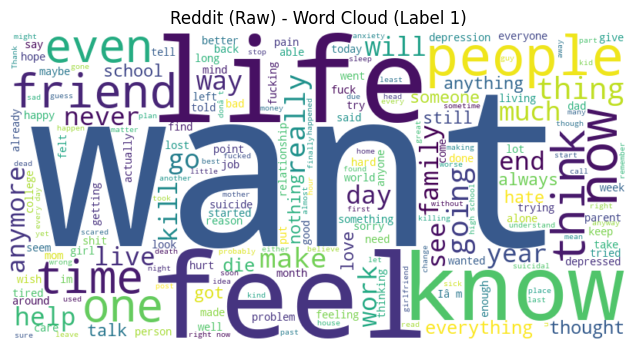

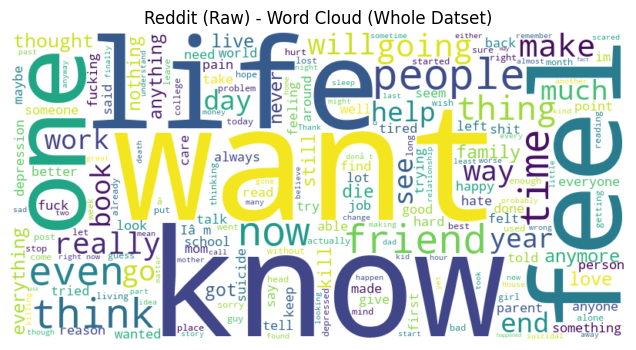


Reddit (Preprocessed) - Label 0 (Top Unigrams):
╒═══════════╤═════════╕
│ Unigram   │   Count │
╞═══════════╪═════════╡
│ just      │    2788 │
├───────────┼─────────┤
│ like      │    2236 │
├───────────┼─────────┤
│ book      │    1854 │
├───────────┼─────────┤
│ read      │    1560 │
├───────────┼─────────┤
│ ve        │    1470 │
├───────────┼─────────┤
│ don       │    1452 │
├───────────┼─────────┤
│ time      │    1351 │
├───────────┼─────────┤
│ know      │    1298 │
├───────────┼─────────┤
│ people    │    1213 │
├───────────┼─────────┤
│ books     │    1140 │
├───────────┼─────────┤
│ life      │    1069 │
├───────────┼─────────┤
│ really    │    1058 │
├───────────┼─────────┤
│ want      │    1030 │
├───────────┼─────────┤
│ think     │    1025 │
├───────────┼─────────┤
│ feel      │     972 │
├───────────┼─────────┤
│ reading   │     942 │
├───────────┼─────────┤
│ way       │     793 │
├───────────┼─────────┤
│ good      │     772 │
├───────────┼─────────┤
│ did       │  

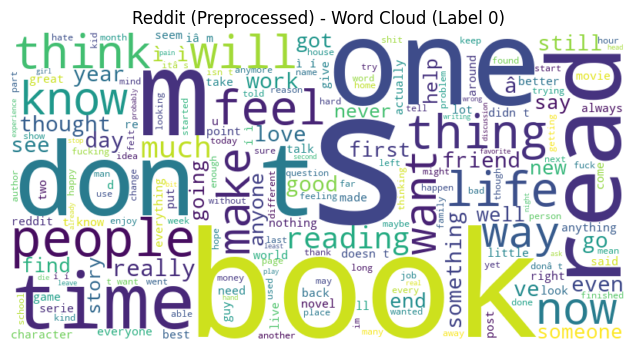


Reddit (Preprocessed) - Label 1 (Top Unigrams):
╒═══════════╤═════════╕
│ Unigram   │   Count │
╞═══════════╪═════════╡
│ just      │   12199 │
├───────────┼─────────┤
│ don       │    9039 │
├───────────┼─────────┤
│ like      │    7957 │
├───────────┼─────────┤
│ want      │    7777 │
├───────────┼─────────┤
│ life      │    6998 │
├───────────┼─────────┤
│ feel      │    6573 │
├───────────┼─────────┤
│ ve        │    6449 │
├───────────┼─────────┤
│ know      │    6399 │
├───────────┼─────────┤
│ time      │    4556 │
├───────────┼─────────┤
│ people    │    4417 │
├───────────┼─────────┤
│ really    │    4005 │
├───────────┼─────────┤
│ going     │    3555 │
├───────────┼─────────┤
│ think     │    3479 │
├───────────┼─────────┤
│ friends   │    3265 │
├───────────┼─────────┤
│ years     │    3094 │
├───────────┼─────────┤
│ help      │    2758 │
├───────────┼─────────┤
│ anymore   │    2656 │
├───────────┼─────────┤
│ things    │    2634 │
├───────────┼─────────┤
│ day       │  

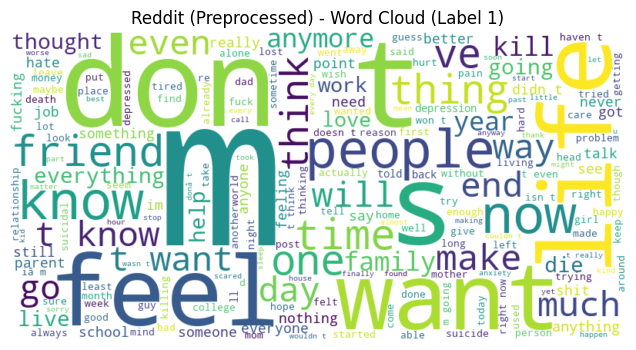

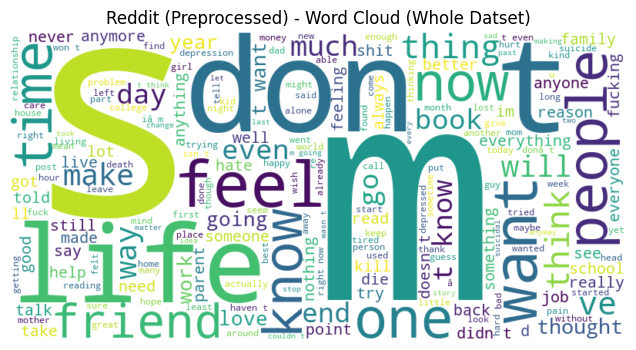

In [59]:
def top_ngrams(corpus, n=1, top_k=20):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def ngram_and_wordcloud_analysis(df, name):
    df = df.copy()
    df['Text'] = df['Text'].fillna('')
    for label in [0, 1]:
        subset = df[df['Label'] == label]['Text']
        if subset.str.strip().str.len().sum() == 0:
            continue
        unigrams = top_ngrams(subset, 1)
        bigrams = top_ngrams(subset, 2)
        trigrams = top_ngrams(subset, 3)
        four_gram = top_ngrams(subset, 4)
        five_gram = top_ngrams(subset, 5)
        six_gram = top_ngrams(subset, 6)
        seven_gram = top_ngrams(subset, 7)
        eight_gram = top_ngrams(subset, 8)
        nine_gram = top_ngrams(subset, 9)
        ten_gram = top_ngrams(subset, 10)

        print(f"\n{name} - Label {label} (Top Unigrams):")
        print(tabulate(unigrams, headers=['Unigram', 'Count'], tablefmt='fancy_grid'))
        print(f"{name} - Label {label} (Top Bigrams):")
        print(tabulate(bigrams, headers=['Bigram', 'Count'], tablefmt='fancy_grid'))
        print(f"{name} - Label {label} (Top Trigrams):")
        print(tabulate(trigrams, headers=['Trigram', 'Count'], tablefmt='fancy_grid'))
        print(f"{name} - Label {label} (Top Four-Grams):")
        print(tabulate(four_gram, headers=['Four-Gram', 'Count'], tablefmt='fancy_grid'))
        print(f"{name} - Label {label} (Top Five-Grams):")
        print(tabulate(five_gram, headers=['Five-Gram', 'Count'], tablefmt='fancy_grid'))
        print(f"{name} - Label {label} (Top Six-Grams):")
        print(tabulate(six_gram, headers=['Six-Gram', 'Count'], tablefmt='fancy_grid'))
        print(f"{name} - Label {label} (Top Seven-Grams):")
        print(tabulate(seven_gram, headers=['Seven-Gram', 'Count'], tablefmt='fancy_grid'))
        print(f"{name} - Label {label} (Top Eight-Grams):")
        print(tabulate(eight_gram, headers=['Eight-Gram', 'Count'], tablefmt='fancy_grid'))
        print(f"{name} - Label {label} (Top Nine-Grams):")
        print(tabulate(nine_gram, headers=['Nine-Gram', 'Count'], tablefmt='fancy_grid'))
        print(f"{name} - Label {label} (Top Ten-Grams):")
        print(tabulate(ten_gram, headers=['Ten-Gram', 'Count'], tablefmt='fancy_grid'))
        plot_wordcloud(subset, f"{name} - Word Cloud (Label {label})")
    plot_wordcloud(df['Text'], f"{name} - Word Cloud (Whole Datset)")

ngram_and_wordcloud_analysis(df_twitter, "Twitter (Raw)")
ngram_and_wordcloud_analysis(df_twitter_preprocessed, "Twitter (Preprocessed)")

ngram_and_wordcloud_analysis(df_reddit, "Reddit (Raw)")
ngram_and_wordcloud_analysis(df_reddit_preprocessed, "Reddit (Preprocessed)")

In [17]:
def sentiment_analysis(df, name):
    sia = SentimentIntensityAnalyzer()
    df = df.copy()
    df['Text'] = df['Text'].fillna('')
    
    # Calculate sentiment scores
    df['vader_sentiment'] = df['Text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    df['textblob_polarity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['textblob_subjectivity'] = df['Text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    
    # Print statistics
    print(f"\n{name} - Sentiment Analysis:")
    sentiment_stats = []
    for label in [0, 1]:
        subset = df[df['Label'] == label]
        sentiment_stats.append([
            f'Label {label}',
            f"{subset['vader_sentiment'].mean():.3f}",
            f"{subset['textblob_polarity'].mean():.3f}",
            f"{subset['textblob_subjectivity'].mean():.3f}",
            len(subset)
        ])
    
    print(tabulate(sentiment_stats, headers=['Class', 'VADER Sentiment', 'TextBlob Polarity', 'TextBlob Subjectivity', 'Count'], tablefmt='fancy_grid'))
    
    def classify_sentiment(score):
        if score >= 0.05:
            return 'Positive'
        elif score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    df['sentiment_category'] = df['vader_sentiment'].apply(classify_sentiment)

    print(f"\n{name} - Sentiment Category Analysis:")
    category_stats = []
    categories = ['Positive', 'Negative', 'Neutral']

    # --- New: Calculate for the Whole Dataset ---
    total_posts_all = len(df)
    counts_all = df['sentiment_category'].value_counts()
    row_all = ['Whole Dataset']
    for category in categories:
        count = counts_all.get(category, 0)
        percentage = (count / total_posts_all) * 100 if total_posts_all > 0 else 0
        row_all.append(f"{count} ({percentage:.1f}%)")
    row_all.append(total_posts_all)
    category_stats.append(row_all)

    # --- Existing: Calculate for each label ---
    for label in [0, 1]:
        subset = df[df['Label'] == label]
        total_posts = len(subset)
        counts = subset['sentiment_category'].value_counts()
        
        row = [f'Label {label}']
        for category in categories:
            count = counts.get(category, 0)
            percentage = (count / total_posts) * 100 if total_posts > 0 else 0
            row.append(f"{count} ({percentage:.1f}%)")
        row.append(total_posts)
        category_stats.append(row)

    print(tabulate(category_stats, headers=['Class'] + categories + ['Total Posts'], tablefmt='fancy_grid'))
        # Plot sentiment distributions
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    for label, color in zip([0, 1], ['green', 'red']):
        sns.kdeplot(df[df['Label']==label]['vader_sentiment'], label=f'Label {label}', color=color)
    plt.title('VADER Sentiment Distribution')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    for label, color in zip([0, 1], ['green', 'red']):
        sns.kdeplot(df[df['Label']==label]['textblob_polarity'], label=f'Label {label}', color=color)
    plt.title('TextBlob Polarity Distribution')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    for label, color in zip([0, 1], ['green', 'red']):
        sns.kdeplot(df[df['Label']==label]['textblob_subjectivity'], label=f'Label {label}', color=color)
    plt.title('TextBlob Subjectivity Distribution')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Twitter (Raw) - Sentiment Analysis:
╒═════════╤═══════════════════╤═════════════════════╤═════════════════════════╤═════════╕
│ Class   │   VADER Sentiment │   TextBlob Polarity │   TextBlob Subjectivity │   Count │
╞═════════╪═══════════════════╪═════════════════════╪═════════════════════════╪═════════╡
│ Label 0 │            -0.091 │              -0.007 │                   0.392 │    5121 │
├─────────┼───────────────────┼─────────────────────┼─────────────────────────┼─────────┤
│ Label 1 │            -0.416 │              -0.007 │                   0.485 │    3998 │
╘═════════╧═══════════════════╧═════════════════════╧═════════════════════════╧═════════╛

Twitter (Raw) - Sentiment Category Analysis:
╒═══════════════╤══════════════╤══════════════╤══════════════╤═══════════════╕
│ Class         │ Positive     │ Negative     │ Neutral      │   Total Posts │
╞═══════════════╪══════════════╪══════════════╪══════════════╪═══════════════╡
│ Whole Dataset │ 2679 (29.4%) │ 5246 (57.5%) │ 11

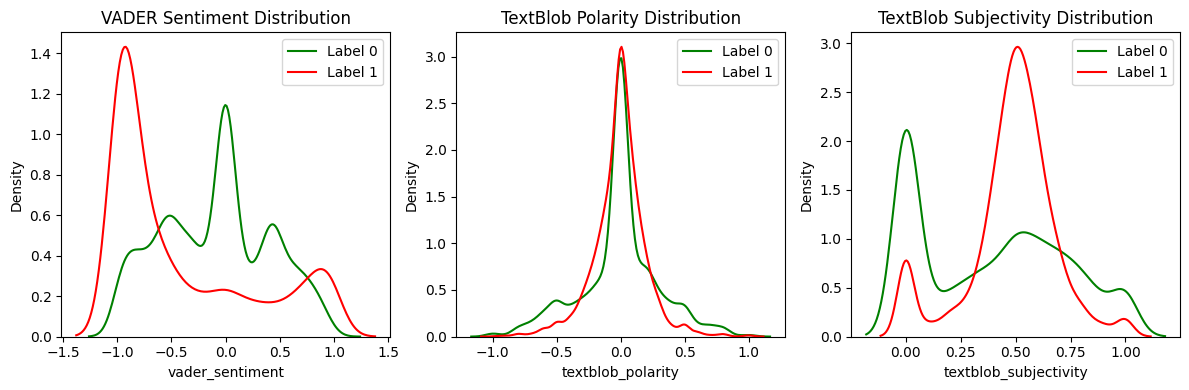


Twitter (Preprocessed) - Sentiment Analysis:
╒═════════╤═══════════════════╤═════════════════════╤═════════════════════════╤═════════╕
│ Class   │   VADER Sentiment │   TextBlob Polarity │   TextBlob Subjectivity │   Count │
╞═════════╪═══════════════════╪═════════════════════╪═════════════════════════╪═════════╡
│ Label 0 │            -0.092 │              -0.007 │                   0.392 │    5121 │
├─────────┼───────────────────┼─────────────────────┼─────────────────────────┼─────────┤
│ Label 1 │            -0.416 │              -0.007 │                   0.484 │    3998 │
╘═════════╧═══════════════════╧═════════════════════╧═════════════════════════╧═════════╛

Twitter (Preprocessed) - Sentiment Category Analysis:
╒═══════════════╤══════════════╤══════════════╤══════════════╤═══════════════╕
│ Class         │ Positive     │ Negative     │ Neutral      │   Total Posts │
╞═══════════════╪══════════════╪══════════════╪══════════════╪═══════════════╡
│ Whole Dataset │ 2678 (29.4%) │

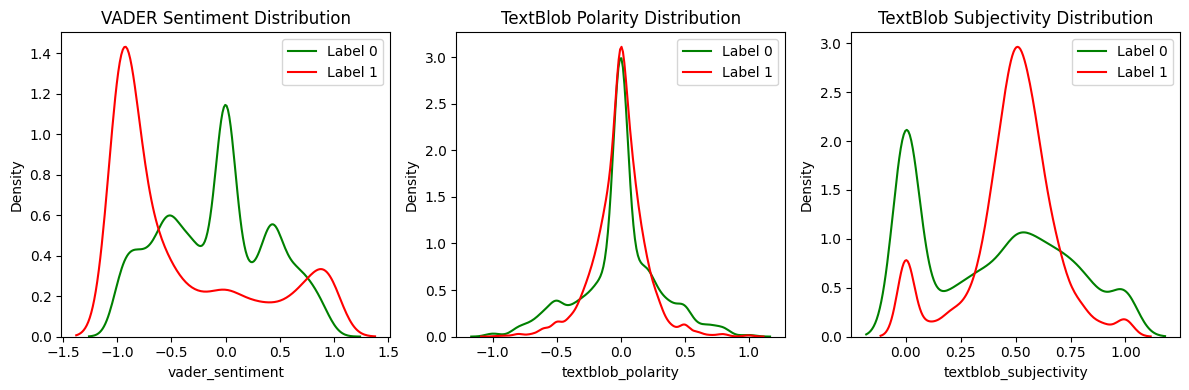


Reddit (Raw) - Sentiment Analysis:
╒═════════╤═══════════════════╤═════════════════════╤═════════════════════════╤═════════╕
│ Class   │   VADER Sentiment │   TextBlob Polarity │   TextBlob Subjectivity │   Count │
╞═════════╪═══════════════════╪═════════════════════╪═════════════════════════╪═════════╡
│ Label 0 │             0.13  │               0.091 │                   0.467 │    6047 │
├─────────┼───────────────────┼─────────────────────┼─────────────────────────┼─────────┤
│ Label 1 │            -0.471 │              -0.003 │                   0.502 │    6609 │
╘═════════╧═══════════════════╧═════════════════════╧═════════════════════════╧═════════╛

Reddit (Raw) - Sentiment Category Analysis:
╒═══════════════╤══════════════╤══════════════╤═════════════╤═══════════════╕
│ Class         │ Positive     │ Negative     │ Neutral     │   Total Posts │
╞═══════════════╪══════════════╪══════════════╪═════════════╪═══════════════╡
│ Whole Dataset │ 4686 (37.0%) │ 7063 (55.8%) │ 907 (7.

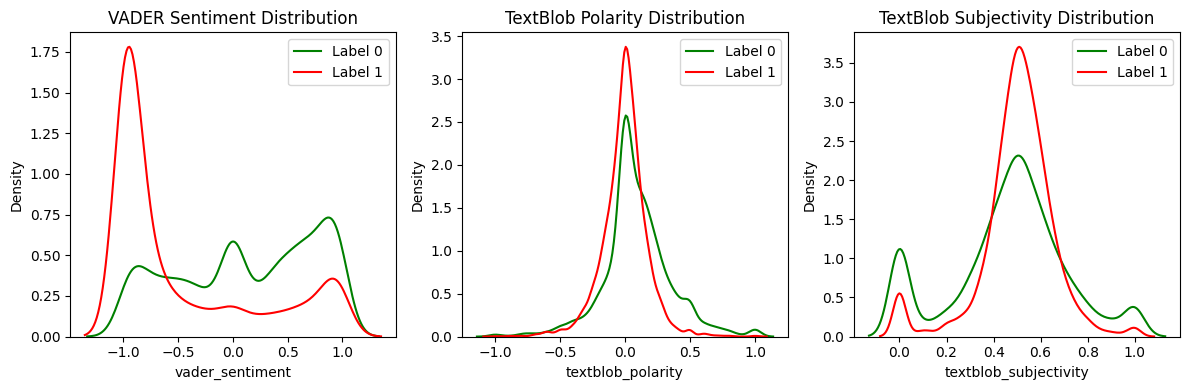


Reddit (Preprocessed) - Sentiment Analysis:
╒═════════╤═══════════════════╤═════════════════════╤═════════════════════════╤═════════╕
│ Class   │   VADER Sentiment │   TextBlob Polarity │   TextBlob Subjectivity │   Count │
╞═════════╪═══════════════════╪═════════════════════╪═════════════════════════╪═════════╡
│ Label 0 │             0.141 │               0.088 │                   0.463 │    6047 │
├─────────┼───────────────────┼─────────────────────┼─────────────────────────┼─────────┤
│ Label 1 │            -0.447 │              -0.003 │                   0.502 │    6609 │
╘═════════╧═══════════════════╧═════════════════════╧═════════════════════════╧═════════╛

Reddit (Preprocessed) - Sentiment Category Analysis:
╒═══════════════╤══════════════╤══════════════╤═════════════╤═══════════════╕
│ Class         │ Positive     │ Negative     │ Neutral     │   Total Posts │
╞═══════════════╪══════════════╪══════════════╪═════════════╪═══════════════╡
│ Whole Dataset │ 4817 (38.1%) │ 6924

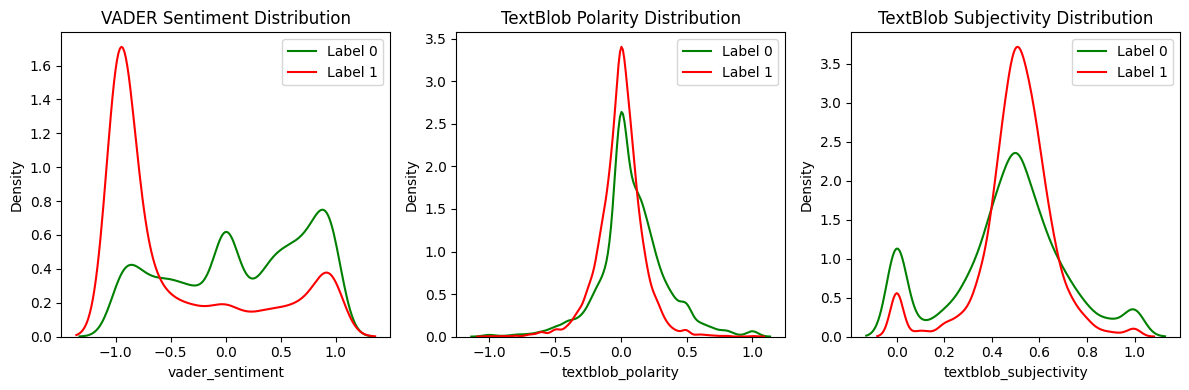

In [18]:
sentiment_analysis(df_twitter, "Twitter (Raw)")
sentiment_analysis(df_twitter_preprocessed, "Twitter (Preprocessed)")
sentiment_analysis(df_reddit, "Reddit (Raw)")
sentiment_analysis(df_reddit_preprocessed, "Reddit (Preprocessed)")

In [19]:
def lexical_analysis(df, name):
    """
    Performs lexical analysis on a DataFrame, providing stats and plots for the
    whole dataset and for individual labels.
    """
    df = df.copy()
    df['Text'] = df['Text'].fillna('')
    
    # --- Calculate Lexical Metrics ---
    df['ttr'] = df['Text'].apply(lambda x: ld.ttr(word_tokenize(x)) if len(word_tokenize(x)) > 0 else 0)
    df['avg_word_length'] = df['Text'].apply(lambda x: np.mean([len(word) for word in word_tokenize(x)]) if len(word_tokenize(x)) > 0 else 0)
    
    print(f"\n{name} - Lexical Analysis:")
    lexical_stats = []
    
    # --- Calculate stats for the Whole Dataset ---
    lexical_stats.append([
        'Whole Dataset',
        f"{df['ttr'].mean():.3f}",
        f"{df['avg_word_length'].mean():.2f}",
        len(df)
    ])

    # --- Calculate stats for each class ---
    for label in [0, 1]:
        subset = df[df['Label'] == label]
        lexical_stats.append([
            f'Label {label}',
            f"{subset['ttr'].mean():.3f}",
            f"{subset['avg_word_length'].mean():.2f}",
            len(subset)
        ])
    
    print(tabulate(lexical_stats, headers=['Class', 'Type-Token Ratio', 'Avg Word Length', 'Count'], tablefmt='fancy_grid'))
    
    # --- Plot Distributions (Updated to include whole dataset) ---
    plt.figure(figsize=(12, 8))
    
    # Plot 1: TTR Comparison (Label 0 vs Label 1)
    plt.subplot(2, 2, 1)
    sns.kdeplot(data=df, x='ttr', hue='Label', palette=['green', 'red'], fill=True)
    plt.title('TTR Comparison by Label')
    
    # Plot 2: Avg Word Length Comparison (Label 0 vs Label 1)
    plt.subplot(2, 2, 2)
    sns.kdeplot(data=df, x='avg_word_length', hue='Label', palette=['green', 'red'], fill=True)
    plt.title('Avg Word Length Comparison by Label')
    
    # Plot 3: TTR for Whole Dataset
    plt.subplot(2, 2, 3)
    sns.kdeplot(data=df, x='ttr', color='blue', fill=True)
    plt.title('TTR Distribution (Whole Dataset)')

    # Plot 4: Avg Word Length for Whole Dataset
    plt.subplot(2, 2, 4)
    sns.kdeplot(data=df, x='avg_word_length', color='purple', fill=True)
    plt.title('Avg Word Length (Whole Dataset)')
    
    plt.tight_layout()
    plt.show()


Twitter (Raw) - Lexical Analysis:
╒═══════════════╤════════════════════╤═══════════════════╤═════════╕
│ Class         │   Type-Token Ratio │   Avg Word Length │   Count │
╞═══════════════╪════════════════════╪═══════════════════╪═════════╡
│ Whole Dataset │              0.828 │              3.89 │    9119 │
├───────────────┼────────────────────┼───────────────────┼─────────┤
│ Label 0       │              0.926 │              3.85 │    5121 │
├───────────────┼────────────────────┼───────────────────┼─────────┤
│ Label 1       │              0.702 │              3.94 │    3998 │
╘═══════════════╧════════════════════╧═══════════════════╧═════════╛


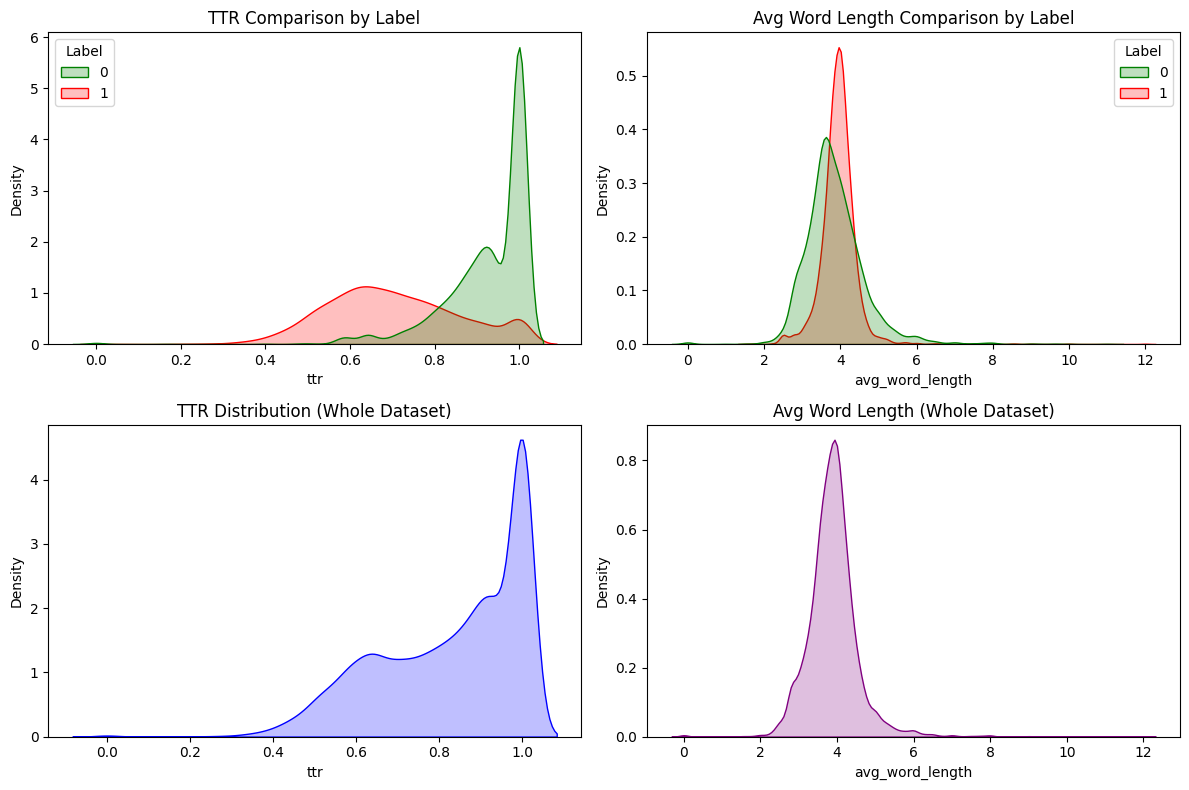


Twitter (Preprocessed) - Lexical Analysis:
╒═══════════════╤════════════════════╤═══════════════════╤═════════╕
│ Class         │   Type-Token Ratio │   Avg Word Length │   Count │
╞═══════════════╪════════════════════╪═══════════════════╪═════════╡
│ Whole Dataset │              0.828 │              3.88 │    9119 │
├───────────────┼────────────────────┼───────────────────┼─────────┤
│ Label 0       │              0.925 │              3.84 │    5121 │
├───────────────┼────────────────────┼───────────────────┼─────────┤
│ Label 1       │              0.702 │              3.94 │    3998 │
╘═══════════════╧════════════════════╧═══════════════════╧═════════╛


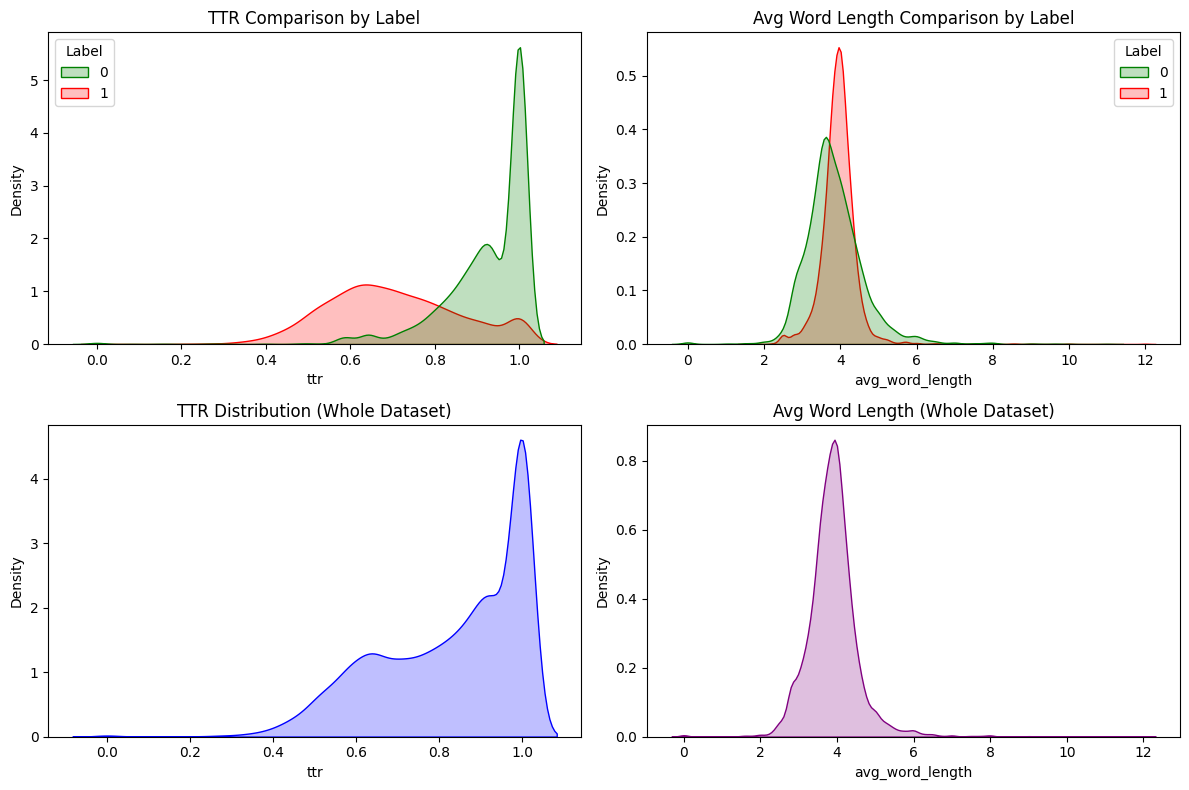


Reddit (Raw) - Lexical Analysis:
╒═══════════════╤════════════════════╤═══════════════════╤═════════╕
│ Class         │   Type-Token Ratio │   Avg Word Length │   Count │
╞═══════════════╪════════════════════╪═══════════════════╪═════════╡
│ Whole Dataset │              0.698 │              3.76 │   12656 │
├───────────────┼────────────────────┼───────────────────┼─────────┤
│ Label 0       │              0.797 │              3.94 │    6047 │
├───────────────┼────────────────────┼───────────────────┼─────────┤
│ Label 1       │              0.607 │              3.59 │    6609 │
╘═══════════════╧════════════════════╧═══════════════════╧═════════╛


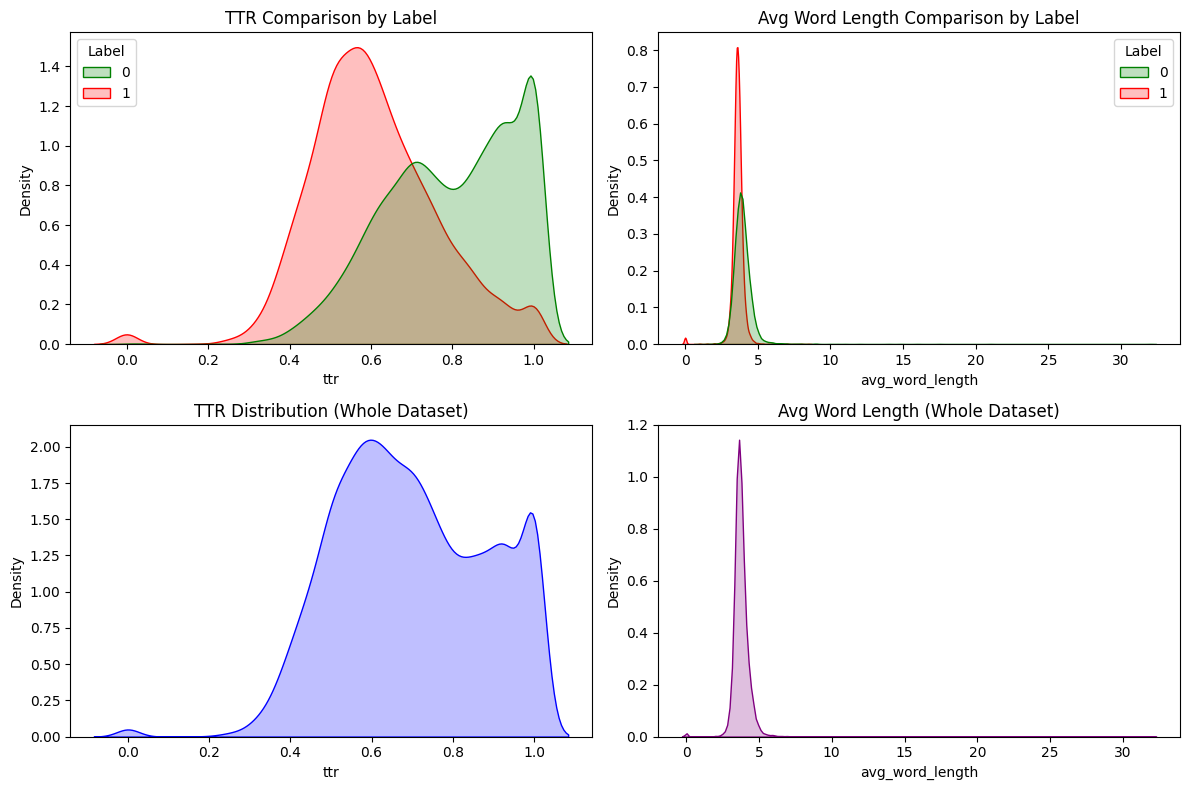


Reddit (Preprocessed) - Lexical Analysis:
╒═══════════════╤════════════════════╤═══════════════════╤═════════╕
│ Class         │   Type-Token Ratio │   Avg Word Length │   Count │
╞═══════════════╪════════════════════╪═══════════════════╪═════════╡
│ Whole Dataset │              0.711 │              3.95 │   12656 │
├───────────────┼────────────────────┼───────────────────┼─────────┤
│ Label 0       │              0.805 │              4.15 │    6047 │
├───────────────┼────────────────────┼───────────────────┼─────────┤
│ Label 1       │              0.625 │              3.76 │    6609 │
╘═══════════════╧════════════════════╧═══════════════════╧═════════╛


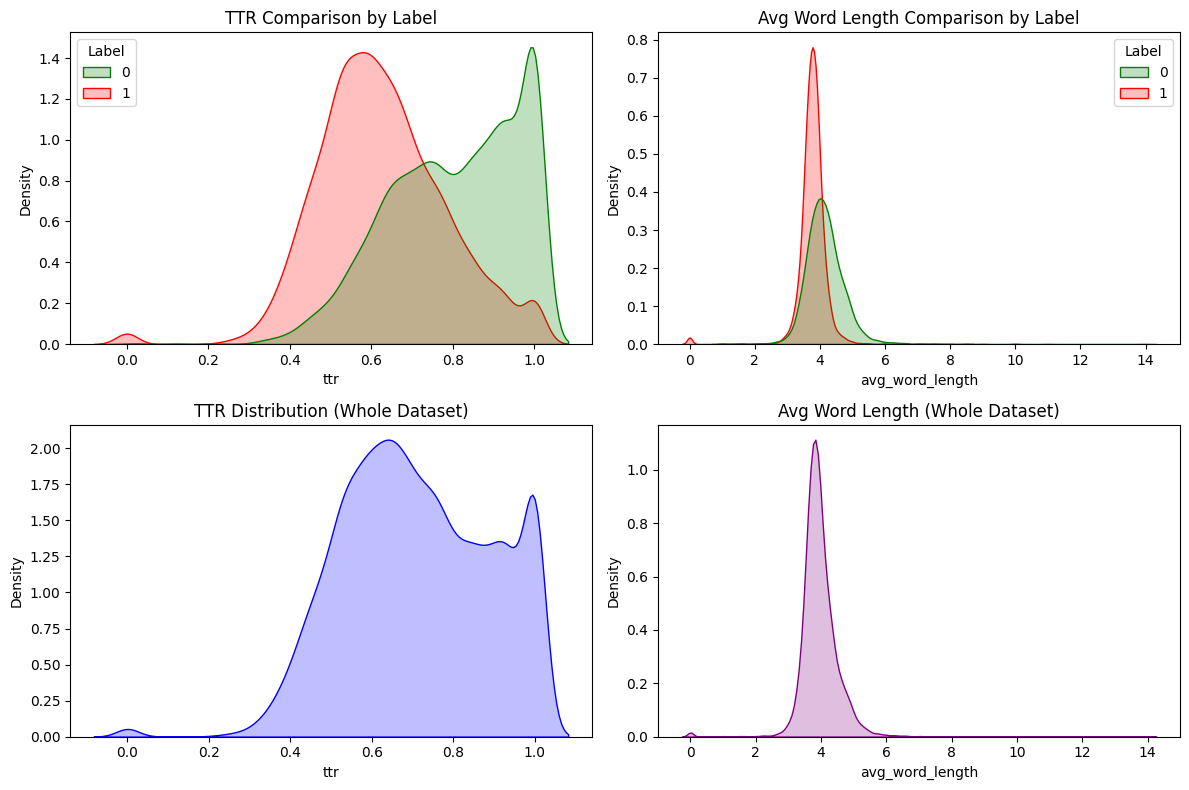

In [20]:
lexical_analysis(df_twitter, "Twitter (Raw)")
lexical_analysis(df_twitter_preprocessed, "Twitter (Preprocessed)")
lexical_analysis(df_reddit, "Reddit (Raw)")
lexical_analysis(df_reddit_preprocessed, "Reddit (Preprocessed)")

In [21]:
def pronoun_analysis(df, name):
    """
    Performs pronoun analysis.

    Calculates the mean count of pronouns per post and the relative percentage
    of each pronoun type within its class. Provides stats and plots for the whole
    dataset and for individual labels.
    """
    df = df.copy()
    df['Text'] = df['Text'].fillna('')
    
    # Define pronoun sets
    first_person = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves'}
    second_person = {'you', 'your', 'yours', 'yourself', 'yourselves'}
    third_person = {'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves'}
    
    def count_pronouns(text, pronoun_set):
        words = word_tokenize(text.lower())
        return sum(1 for word in words if word in pronoun_set)
    
    df['first_person_count'] = df['Text'].apply(lambda x: count_pronouns(x, first_person))
    df['second_person_count'] = df['Text'].apply(lambda x: count_pronouns(x, second_person))
    df['third_person_count'] = df['Text'].apply(lambda x: count_pronouns(x, third_person))
    df['total_pronouns'] = df['first_person_count'] + df['second_person_count'] + df['third_person_count']
    
    print(f"\n{name} - Pronoun Analysis:")
    print("(Table shows mean pronouns per post and the relative % of total pronouns for that class)")
    
    pronoun_stats = []
    
    # Process data for the Whole Dataset and for each Label
    data_slices = [('Whole Dataset', df)] + [(f'Label {label}', df[df['Label'] == label]) for label in [0, 1]]

    for slice_name, data in data_slices:
        if data.empty:
            continue
            
        total_first = data['first_person_count'].sum()
        total_second = data['second_person_count'].sum()
        total_third = data['third_person_count'].sum()
        grand_total = total_first + total_second + total_third

        pct_first = (total_first / grand_total) * 100 if grand_total > 0 else 0
        pct_second = (total_second / grand_total) * 100 if grand_total > 0 else 0
        pct_third = (total_third / grand_total) * 100 if grand_total > 0 else 0
        
        pronoun_stats.append([
            slice_name,
            f"{data['first_person_count'].mean():.2f} ({pct_first:.1f}%)",
            f"{data['second_person_count'].mean():.2f} ({pct_second:.1f}%)",
            f"{data['third_person_count'].mean():.2f} ({pct_third:.1f}%)",
            f"{data['total_pronouns'].mean():.2f}",
            len(data)
        ])

    headers = ['Class', '1st Person (Mean & %)', '2nd Person (Mean & %)', '3rd Person (Mean & %)', 'Total Pronouns (Mean)', 'Count']
    print(tabulate(pronoun_stats, headers=headers, tablefmt='fancy_grid'))
    
    # --- Plot pronoun distributions (Updated to include whole dataset plots) ---
    plt.figure(figsize=(18, 8))
    
    plot_cols = ['first_person_count', 'second_person_count', 'third_person_count', 'total_pronouns']
    plot_titles = ['1st Person', '2nd Person', '3rd Person', 'Total']

    for i, (col, title) in enumerate(zip(plot_cols, plot_titles)):
        # --- Top Row: Comparison by Label ---
        plt.subplot(2, 4, i + 1)
        upper_limit = df[col].quantile(0.95)
        sns.kdeplot(data=df, x=col, hue='Label', palette=['green', 'red'], fill=True, clip=(0, upper_limit))
        plt.title(f'{title} Pronouns (by Label)')
        
        # --- Bottom Row: Whole Dataset Distribution ---
        plt.subplot(2, 4, i + 5)
        sns.kdeplot(data=df, x=col, color='blue', fill=True, clip=(0, upper_limit))
        plt.title(f'{title} Pronouns (Whole Dataset)')
        
    plt.tight_layout()
    plt.show()


Twitter (Raw) - Pronoun Analysis:
(Table shows mean pronouns per post and the relative % of total pronouns for that class)
╒═══════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════╕
│ Class         │ 1st Person (Mean & %)   │ 2nd Person (Mean & %)   │ 3rd Person (Mean & %)   │   Total Pronouns (Mean) │   Count │
╞═══════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════╡
│ Whole Dataset │ 8.76 (72.9%)            │ 0.51 (4.3%)             │ 2.74 (22.8%)            │                   12.02 │    9119 │
├───────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼─────────┤
│ Label 0       │ 1.82 (67.2%)            │ 0.26 (9.4%)             │ 0.63 (23.3%)            │                    2.71 │    5121 │
├───────────────┼─────────────────────────┼─────────────────────────┼───────────────

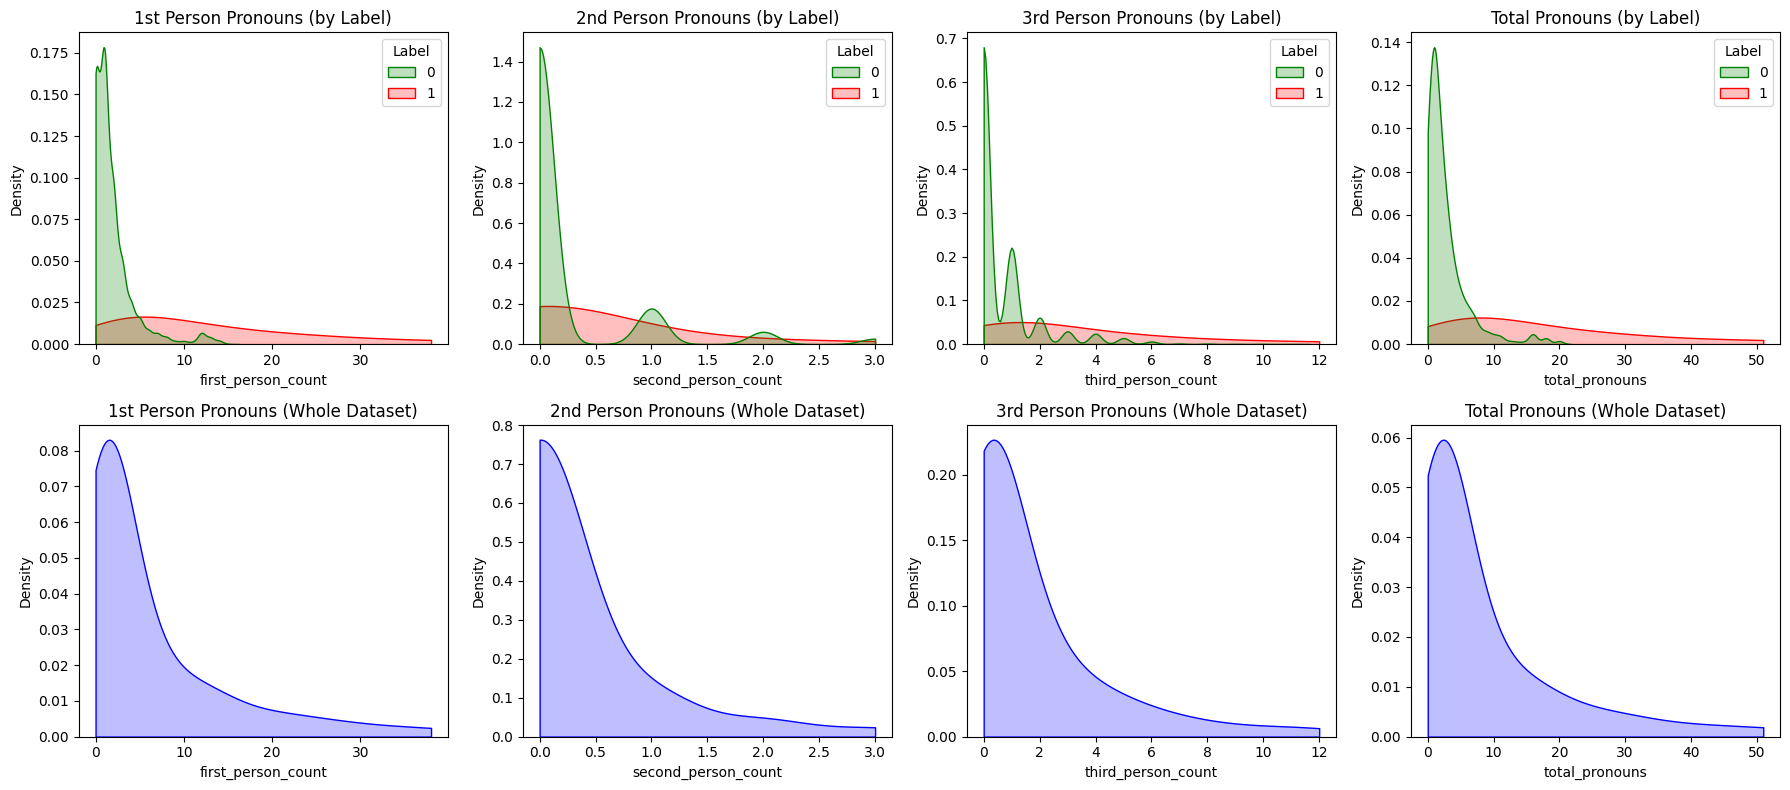


Twitter (Preprocessed) - Pronoun Analysis:
(Table shows mean pronouns per post and the relative % of total pronouns for that class)
╒═══════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════╕
│ Class         │ 1st Person (Mean & %)   │ 2nd Person (Mean & %)   │ 3rd Person (Mean & %)   │   Total Pronouns (Mean) │   Count │
╞═══════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════╡
│ Whole Dataset │ 8.76 (72.9%)            │ 0.51 (4.3%)             │ 2.74 (22.8%)            │                   12.02 │    9119 │
├───────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼─────────┤
│ Label 0       │ 1.82 (67.2%)            │ 0.26 (9.4%)             │ 0.63 (23.3%)            │                    2.71 │    5121 │
├───────────────┼─────────────────────────┼─────────────────────────┼──────

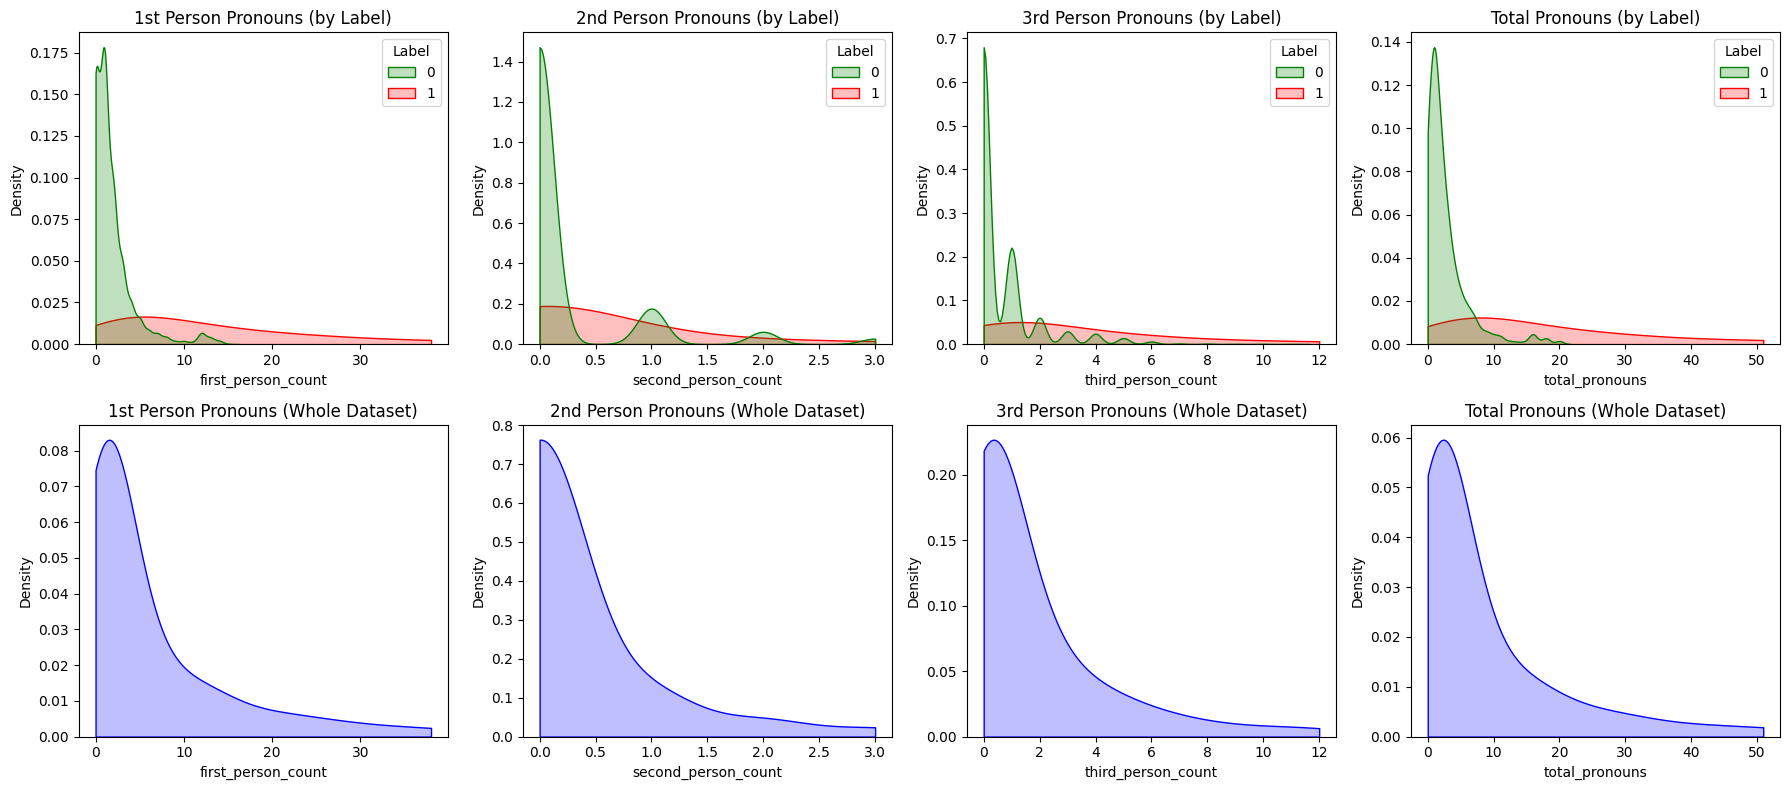


Reddit (Raw) - Pronoun Analysis:
(Table shows mean pronouns per post and the relative % of total pronouns for that class)
╒═══════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════╕
│ Class         │ 1st Person (Mean & %)   │ 2nd Person (Mean & %)   │ 3rd Person (Mean & %)   │   Total Pronouns (Mean) │   Count │
╞═══════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════╡
│ Whole Dataset │ 16.37 (70.5%)           │ 1.15 (5.0%)             │ 5.70 (24.6%)            │                   23.23 │   12656 │
├───────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼─────────┤
│ Label 0       │ 5.25 (56.0%)            │ 1.17 (12.5%)            │ 2.96 (31.5%)            │                    9.38 │    6047 │
├───────────────┼─────────────────────────┼─────────────────────────┼────────────────

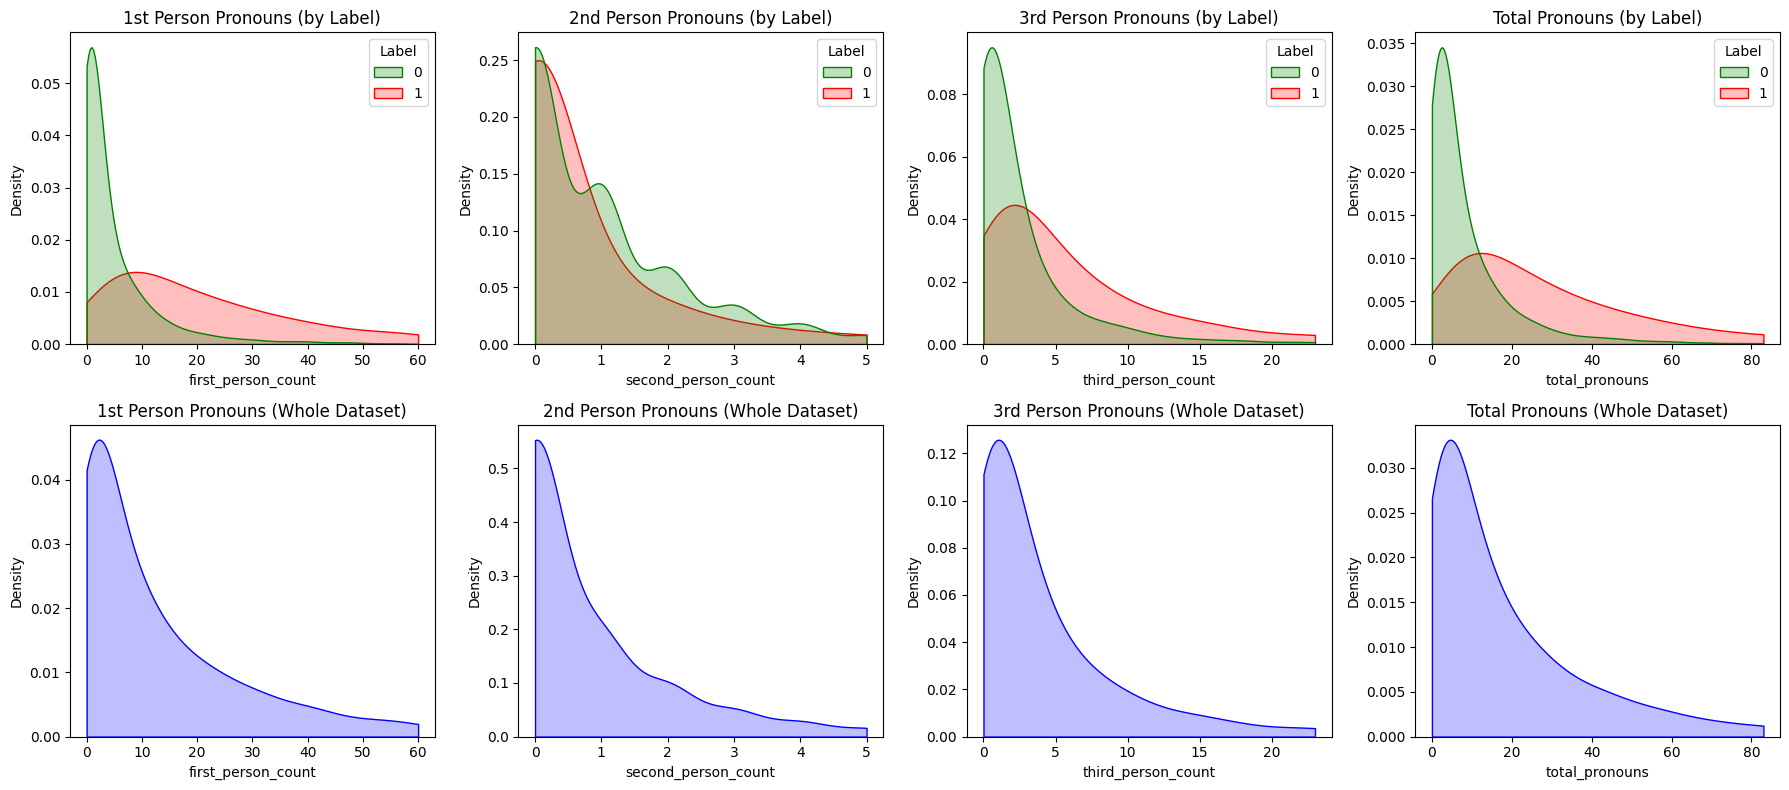


Reddit (Preprocessed) - Pronoun Analysis:
(Table shows mean pronouns per post and the relative % of total pronouns for that class)
╒═══════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤═════════╕
│ Class         │ 1st Person (Mean & %)   │ 2nd Person (Mean & %)   │ 3rd Person (Mean & %)   │   Total Pronouns (Mean) │   Count │
╞═══════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪═════════╡
│ Whole Dataset │ 16.72 (70.6%)           │ 1.16 (4.9%)             │ 5.78 (24.4%)            │                   23.66 │   12656 │
├───────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼─────────────────────────┼─────────┤
│ Label 0       │ 5.36 (56.2%)            │ 1.18 (12.4%)            │ 3.00 (31.4%)            │                    9.54 │    6047 │
├───────────────┼─────────────────────────┼─────────────────────────┼───────

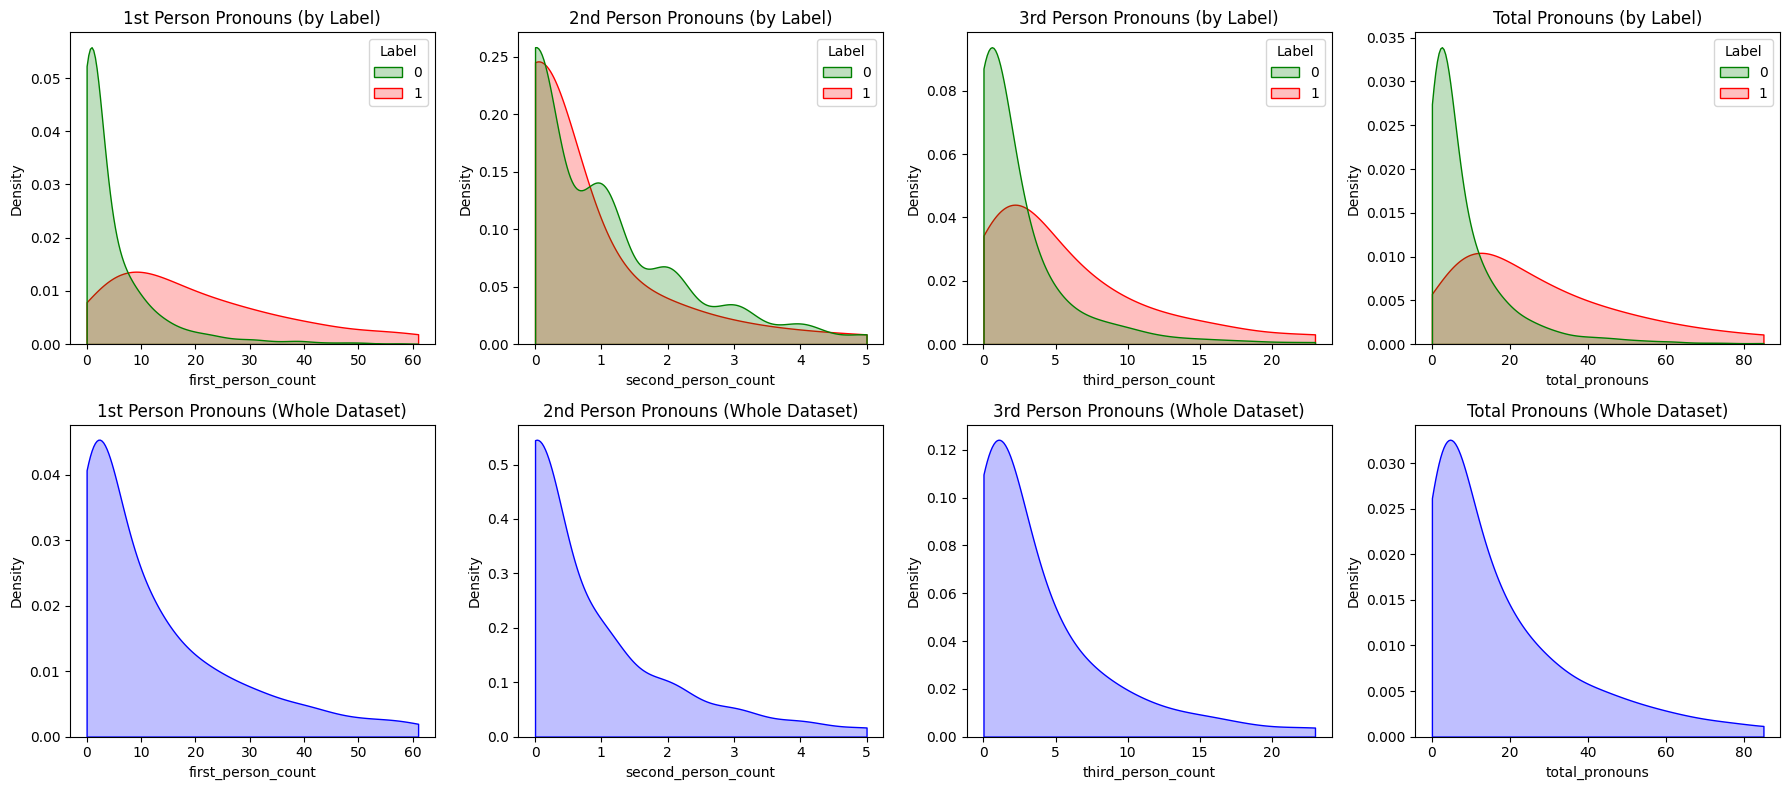

In [22]:
pronoun_analysis(df_twitter, "Twitter (Raw)")
pronoun_analysis(df_twitter_preprocessed, "Twitter (Preprocessed)")
pronoun_analysis(df_reddit, "Reddit (Raw)")
pronoun_analysis(df_reddit_preprocessed, "Reddit (Preprocessed)")

In [23]:
def named_entity_analysis(df, name):
    # --- Initialize spaCy pipeline inside the function ---
    nlp_pipeline = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])

    df = df.copy()
    df['Text'] = df['Text'].fillna('')

    # --- 1. Named Entity Analysis (Accelerated) ---
    docs = nlp_pipeline.pipe(df['Text'].astype(str), n_process=-1)

    entity_counts_list = []
    for doc in docs:
        counts = Counter(ent.label_ for ent in doc.ents)
        entity_counts_list.append(counts)

    entity_counts_df = pd.DataFrame(entity_counts_list, index=df.index).fillna(0)
    entity_types = ['PERSON', 'ORG', 'GPE', 'DATE', 'TIME']
    for ent_type in entity_types:
        if ent_type not in entity_counts_df:
            entity_counts_df[ent_type] = 0
    
    df_plot = df.join(entity_counts_df[entity_types])

    print(f"\n{name} - Named Entity Analysis")
    print("(Shows mean entities per post)")
    entity_stats = []

    data_slices = [('Whole Dataset', df_plot)] + [(f'Label {label}', df_plot[df_plot['Label'] == label]) for label in [0, 1]]

    for slice_name, data_slice in data_slices:
        if data_slice.empty:
            continue
        row = [slice_name]
        for ent_type in entity_types:
            mean_val = data_slice[ent_type].mean()
            row.append(f"{mean_val:.2f}")
        row.append(len(data_slice))
        entity_stats.append(row)

    headers = ['Class'] + entity_types + ['Post Count']
    print(tabulate(entity_stats, headers=headers, tablefmt='fancy_grid'))
    
    # --- 2. Keyword Analysis ---
    print(f"\n{name} - Keyword Analysis")
    print("(Shows count and % of posts in the class containing the keyword)")
    
    keywords = ['die', 'help', 'alone', 'kill', 'suicide', 'death']
    keyword_stats = []

    text_slices = [('Whole Dataset', df['Text'])] + [(f'Label {label}', df[df['Label'] == label]['Text']) for label in [0, 1]]

    for slice_name, text_slice in text_slices:
        if text_slice.empty:
            continue
        row = [slice_name]
        for keyword in keywords:
            count = sum(1 for text in text_slice if keyword.lower() in text.lower())
            percentage = (count / len(text_slice)) * 100 if len(text_slice) > 0 else 0
            row.append(f"{count} ({percentage:.1f}%)")
        row.append(len(text_slice))
        keyword_stats.append(row)
    
    headers = ['Class'] + keywords + ['Total Posts']
    print(tabulate(keyword_stats, headers=headers, tablefmt='fancy_grid'))

    # --- 3. Plotting ---

    # Plot Named Entity Distributions
    plt.figure(figsize=(15, 5))
    for i, ent_type in enumerate(entity_types):
        plt.subplot(2, 3, i + 1)
        upper_limit = df_plot[ent_type].quantile(0.99)
        sns.kdeplot(data=df_plot, x=ent_type, hue='Label', palette=['green', 'red'], fill=True, clip=(0, upper_limit))
        plt.title(f'Distribution of {ent_type}')
    plt.suptitle(f'{name} - Named Entity Distributions per Post', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- Plot Keyword Presence Counts (Consolidated Graph) ---
    
    # Create boolean columns for keyword presence
    for keyword in keywords:
        df_plot[keyword] = df_plot['Text'].str.lower().str.contains(keyword, na=False)
        
    # Reshape the data from wide to long format for easy plotting
    melted_df = df_plot.melt(id_vars=['Label'], value_vars=keywords, var_name='Keyword', value_name='Has_Keyword')
    
    # Filter for rows where the keyword is present
    keyword_present_df = melted_df[melted_df['Has_Keyword'] == True]
    
    # Create a single count plot
    plt.figure(figsize=(12, 6))
    sns.countplot(data=keyword_present_df, x='Keyword', hue='Label', palette=['green', 'red'], order=keywords)
    plt.title(f'{name} - Keyword Presence in Posts', fontsize=16)
    plt.ylabel('Number of Posts')
    plt.xlabel('Keyword')
    plt.tight_layout()
    plt.show()


Twitter (Raw) - Named Entity Analysis
(Shows mean entities per post)
╒═══════════════╤══════════╤═══════╤═══════╤════════╤════════╤══════════════╕
│ Class         │   PERSON │   ORG │   GPE │   DATE │   TIME │   Post Count │
╞═══════════════╪══════════╪═══════╪═══════╪════════╪════════╪══════════════╡
│ Whole Dataset │     0.13 │  0.07 │  0.05 │   0.71 │   0.15 │         9119 │
├───────────────┼──────────┼───────┼───────┼────────┼────────┼──────────────┤
│ Label 0       │     0.09 │  0.03 │  0.04 │   0.19 │   0.07 │         5121 │
├───────────────┼──────────┼───────┼───────┼────────┼────────┼──────────────┤
│ Label 1       │     0.19 │  0.13 │  0.06 │   1.38 │   0.27 │         3998 │
╘═══════════════╧══════════╧═══════╧═══════╧════════╧════════╧══════════════╛

Twitter (Raw) - Keyword Analysis
(Shows count and % of posts in the class containing the keyword)
╒═══════════════╤══════════════╤══════════════╤═════════════╤══════════════╤═════════════╤════════════╤═══════════════╕
│ Class  

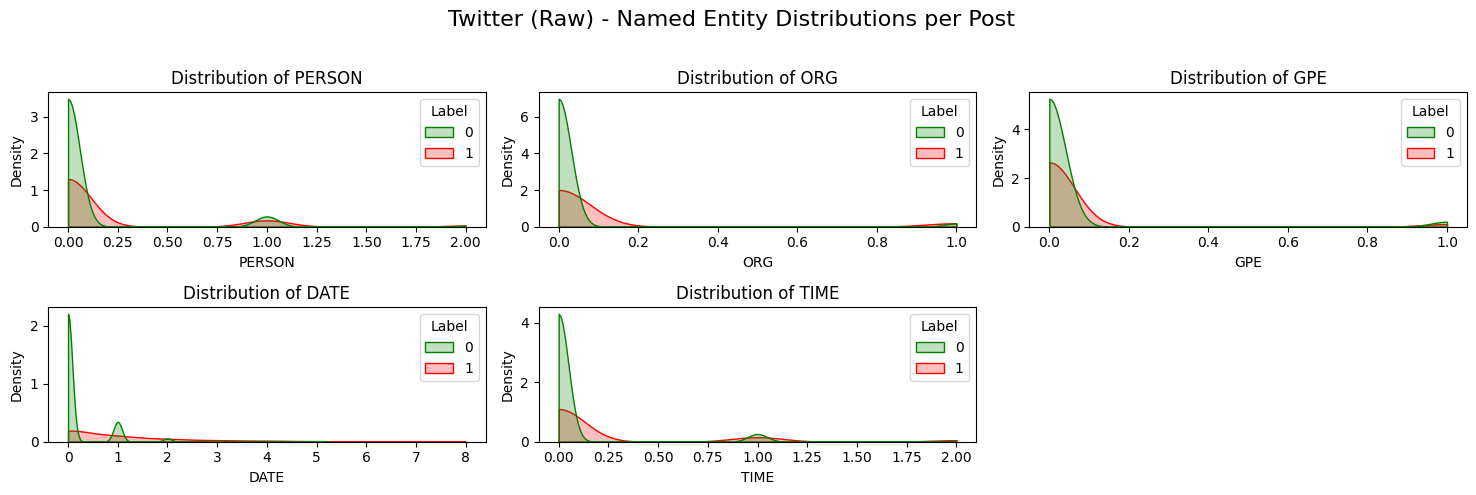

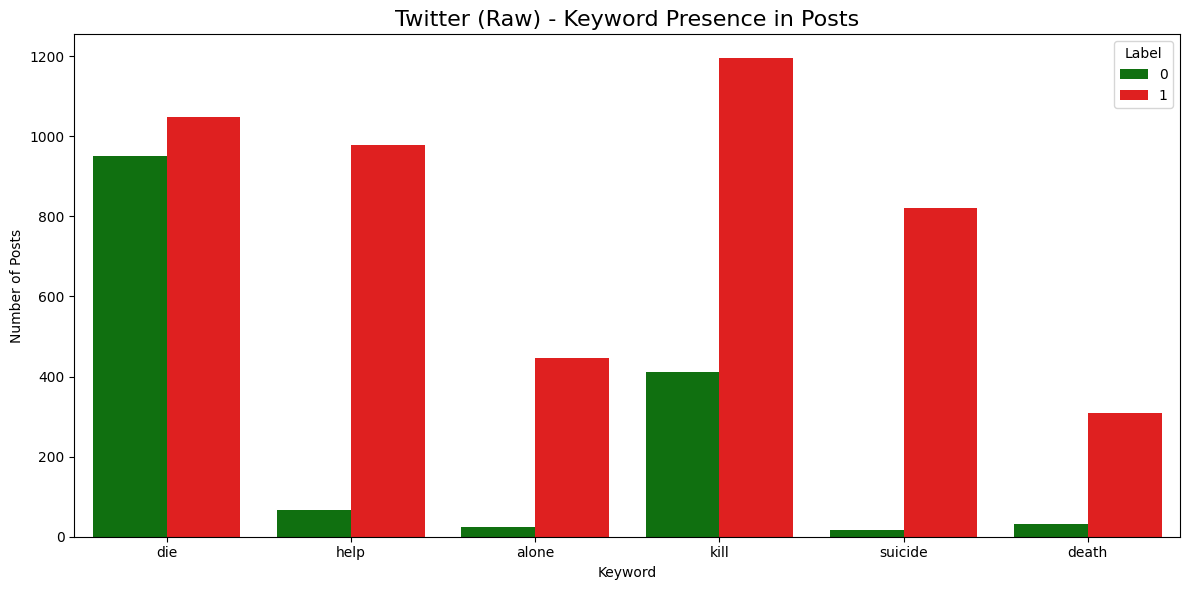


Twitter (Preprocessed) - Named Entity Analysis
(Shows mean entities per post)
╒═══════════════╤══════════╤═══════╤═══════╤════════╤════════╤══════════════╕
│ Class         │   PERSON │   ORG │   GPE │   DATE │   TIME │   Post Count │
╞═══════════════╪══════════╪═══════╪═══════╪════════╪════════╪══════════════╡
│ Whole Dataset │     0.14 │  0.07 │  0.05 │   0.71 │   0.15 │         9119 │
├───────────────┼──────────┼───────┼───────┼────────┼────────┼──────────────┤
│ Label 0       │     0.1  │  0.03 │  0.04 │   0.19 │   0.07 │         5121 │
├───────────────┼──────────┼───────┼───────┼────────┼────────┼──────────────┤
│ Label 1       │     0.19 │  0.13 │  0.06 │   1.38 │   0.27 │         3998 │
╘═══════════════╧══════════╧═══════╧═══════╧════════╧════════╧══════════════╛

Twitter (Preprocessed) - Keyword Analysis
(Shows count and % of posts in the class containing the keyword)
╒═══════════════╤══════════════╤══════════════╤═════════════╤══════════════╤═════════════╤════════════╤════════

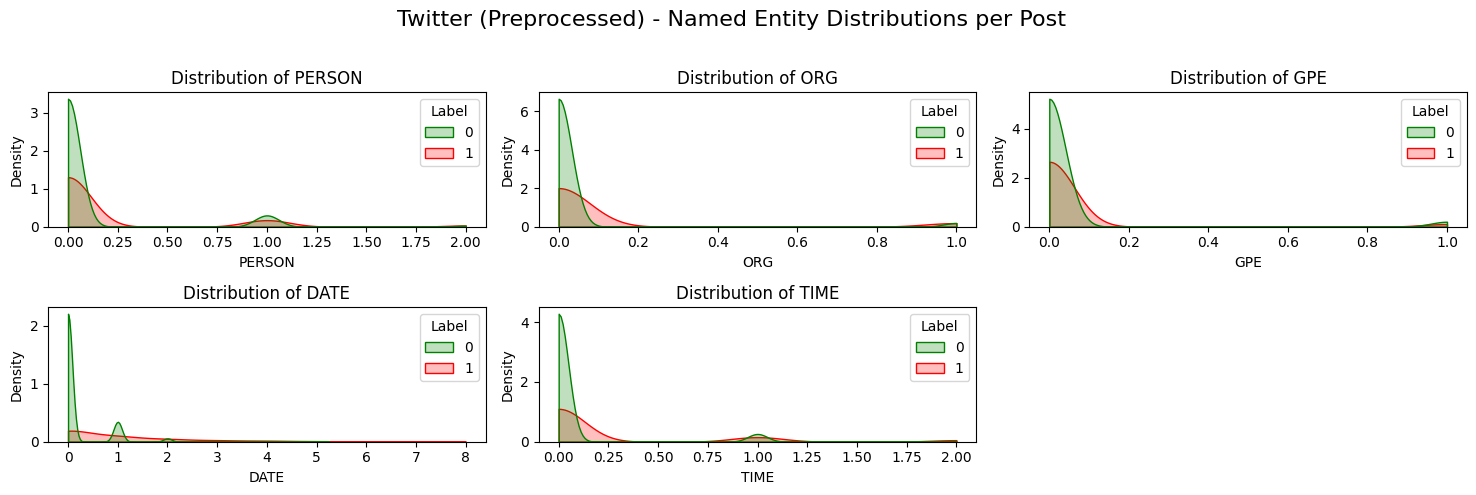

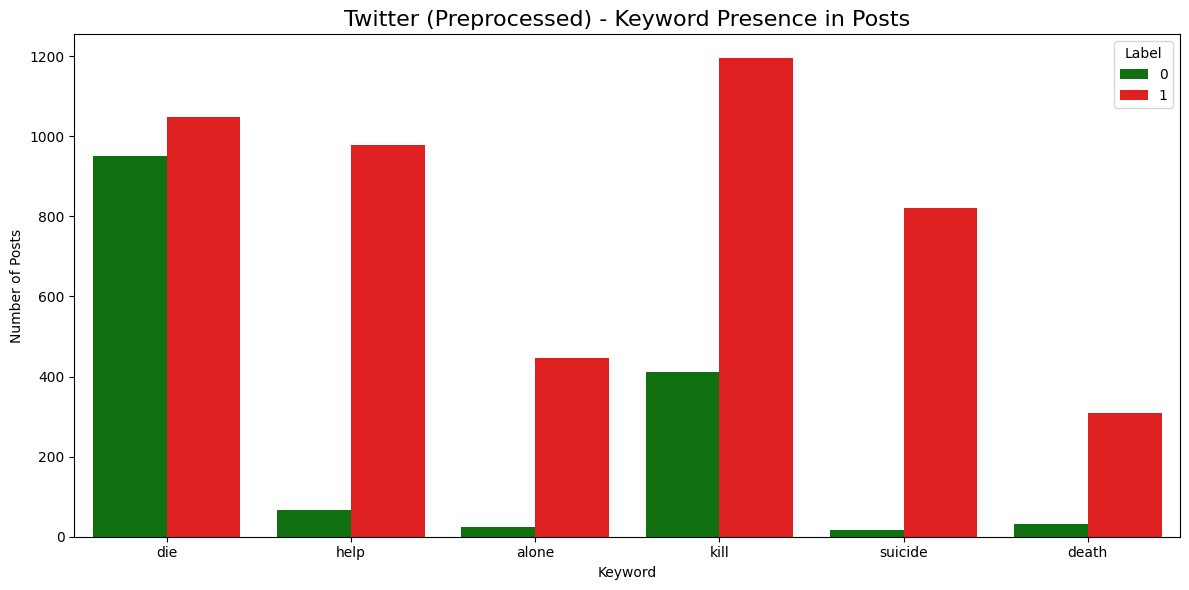


Reddit (Raw) - Named Entity Analysis
(Shows mean entities per post)
╒═══════════════╤══════════╤═══════╤═══════╤════════╤════════╤══════════════╕
│ Class         │   PERSON │   ORG │   GPE │   DATE │   TIME │   Post Count │
╞═══════════════╪══════════╪═══════╪═══════╪════════╪════════╪══════════════╡
│ Whole Dataset │     0.56 │  0.47 │  0.21 │   1.42 │   0.25 │        12656 │
├───────────────┼──────────┼───────┼───────┼────────┼────────┼──────────────┤
│ Label 0       │     0.85 │  0.66 │  0.26 │   0.62 │   0.13 │         6047 │
├───────────────┼──────────┼───────┼───────┼────────┼────────┼──────────────┤
│ Label 1       │     0.29 │  0.29 │  0.17 │   2.15 │   0.37 │         6609 │
╘═══════════════╧══════════╧═══════╧═══════╧════════╧════════╧══════════════╛

Reddit (Raw) - Keyword Analysis
(Shows count and % of posts in the class containing the keyword)
╒═══════════════╤══════════════╤══════════════╤═════════════╤══════════════╤══════════════╤════════════╤═══════════════╕
│ Class   

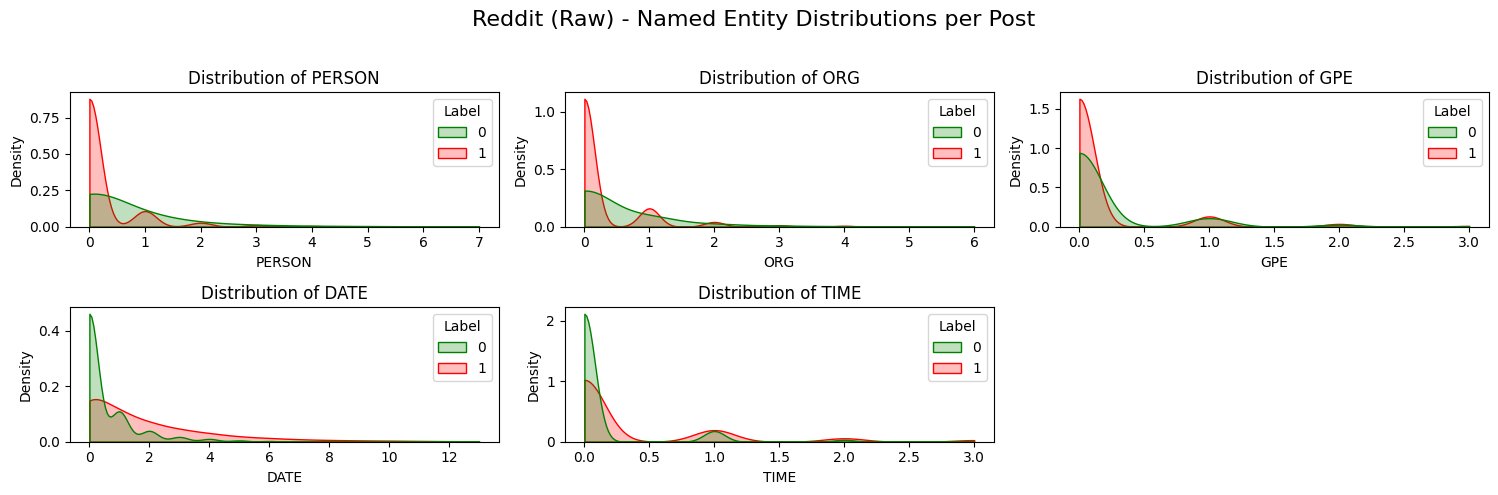

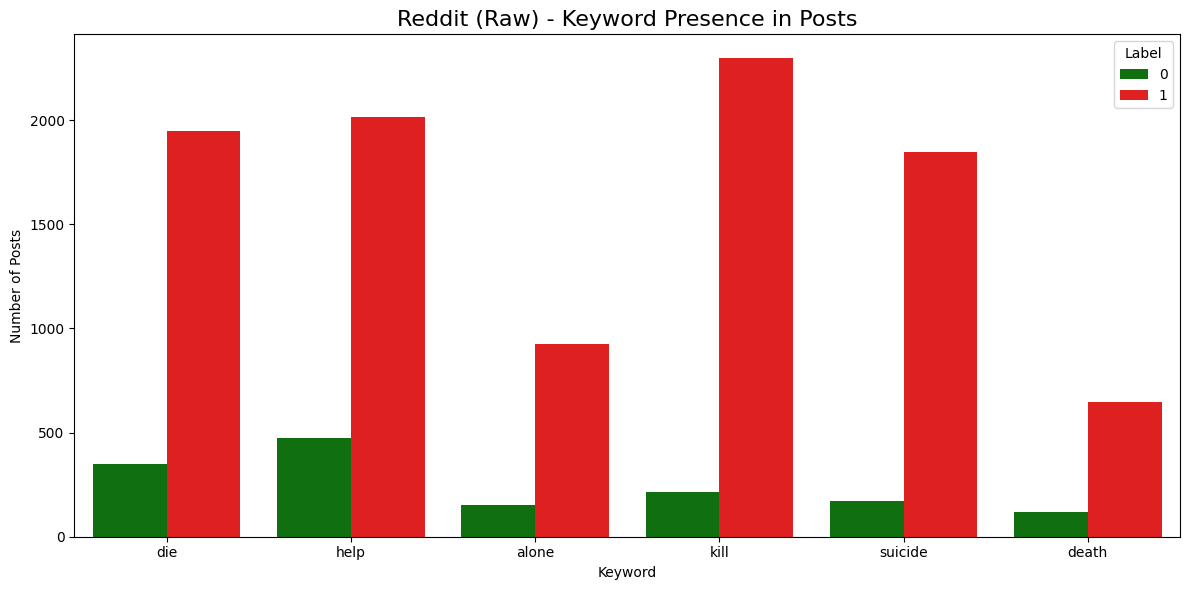


Reddit (Preprocessed) - Named Entity Analysis
(Shows mean entities per post)
╒═══════════════╤══════════╤═══════╤═══════╤════════╤════════╤══════════════╕
│ Class         │   PERSON │   ORG │   GPE │   DATE │   TIME │   Post Count │
╞═══════════════╪══════════╪═══════╪═══════╪════════╪════════╪══════════════╡
│ Whole Dataset │     0.43 │  0.07 │  0.12 │   1.36 │   0.27 │        12656 │
├───────────────┼──────────┼───────┼───────┼────────┼────────┼──────────────┤
│ Label 0       │     0.47 │  0.11 │  0.14 │   0.63 │   0.13 │         6047 │
├───────────────┼──────────┼───────┼───────┼────────┼────────┼──────────────┤
│ Label 1       │     0.4  │  0.04 │  0.09 │   2.03 │   0.39 │         6609 │
╘═══════════════╧══════════╧═══════╧═══════╧════════╧════════╧══════════════╛

Reddit (Preprocessed) - Keyword Analysis
(Shows count and % of posts in the class containing the keyword)
╒═══════════════╤══════════════╤══════════════╤═════════════╤══════════════╤══════════════╤════════════╤═════════

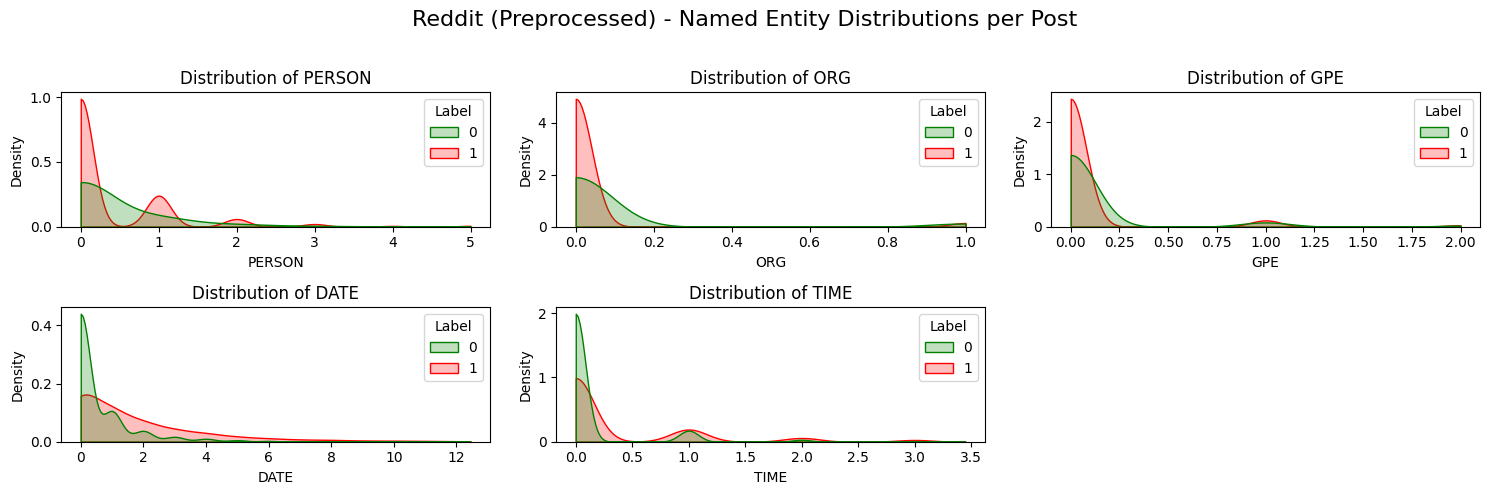

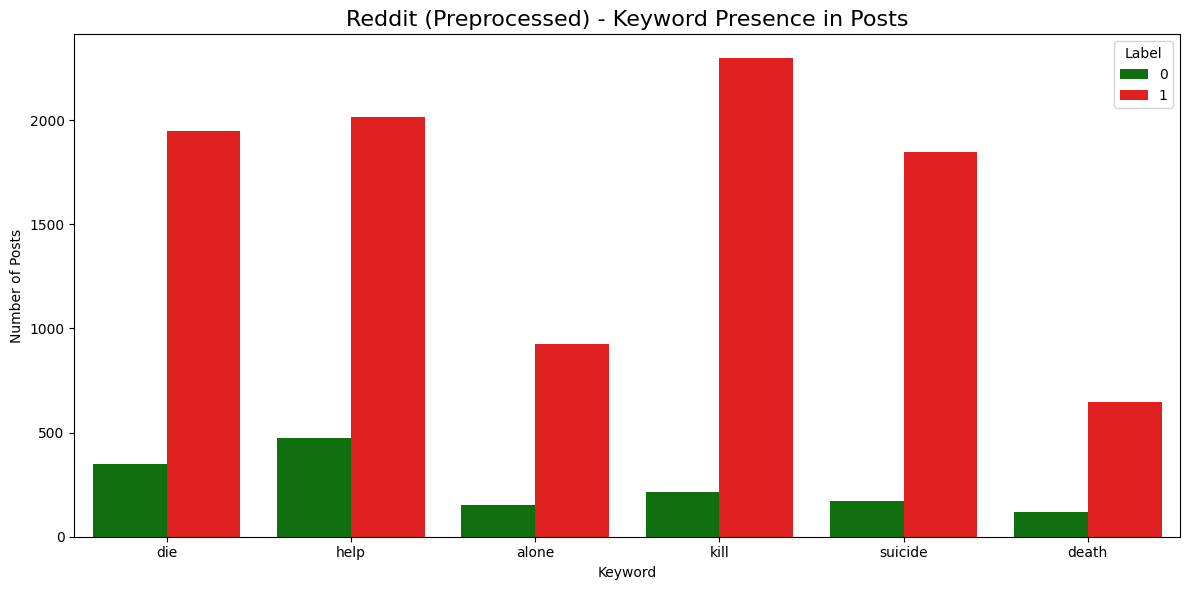

In [24]:
named_entity_analysis(df_twitter, "Twitter (Raw)")
named_entity_analysis(df_twitter_preprocessed, "Twitter (Preprocessed)")
named_entity_analysis(df_reddit, "Reddit (Raw)")
named_entity_analysis(df_reddit_preprocessed, "Reddit (Preprocessed)")

In [25]:
def topic_modeling(df, name, n_topics=5):
    print(f"\n{name} - Topic Modeling Analysis")
    df = df.copy()
    df['Text'] = df['Text'].fillna('')

    # --- Topic Modeling for the Whole Dataset ---
    print("\n--- Topics for Whole Dataset ---")
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(df['Text'])
    
    if X.shape[1] > 0:
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='online', n_jobs=-1)
        lda.fit(X)
        
        feature_names = vectorizer.get_feature_names_out()
        for idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
            print(f"Topic #{idx+1}: {', '.join(top_words)}")
    else:
        print("Not enough data to perform topic modeling on the whole dataset.")

    # --- Topic Modeling for Each Label ---
    for label in [0, 1]:
        print(f"\n--- Topics for Label {label} ---")
        
        # Filter the dataframe for the specific label
        subset_df = df[df['Label'] == label]

        if subset_df.empty or subset_df['Text'].str.isspace().all():
            print("No text data available for this label to perform topic modeling.")
            continue

        # Vectorize the text data
        vectorizer = CountVectorizer(stop_words='english', max_features=1000)
        X = vectorizer.fit_transform(subset_df['Text'])
        
        # Check if the vocabulary is empty
        if X.shape[1] == 0:
            print("Vocabulary is empty after removing stop words. Cannot perform topic modeling.")
            continue

        # Fit the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='online', n_jobs=-1)
        lda.fit(X)
        
        # Print the top words for each topic
        feature_names = vectorizer.get_feature_names_out()
        for idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[-10:][::-1]]
            print(f"Topic #{idx+1}: {', '.join(top_words)}")

In [26]:
topic_modeling(df_twitter, "Twitter (Raw)")
topic_modeling(df_twitter_preprocessed, "Twitter (Preprocessed)")
topic_modeling(df_reddit, "Reddit (Raw)")
topic_modeling(df_reddit_preprocessed, "Reddit (Preprocessed)")


Twitter (Raw) - Topic Modeling Analysis

--- Topics for Whole Dataset ---
Topic #1: dont, just, life, ive, know, feel, like, want, people, suicide
Topic #2: just, like, feel, going, sorry, tired, good, hope, sad, need
Topic #3: got, work, time, day, didnt, home, started, job, went, night
Topic #4: want, die, hate, just, dont, feel, like, fucking, body, heart
Topic #5: just, don, kill, know, school, like, want, people, think, ve

--- Topics for Label 0 ---
Topic #1: like, people, really, leave, sun, know, dark, don, going, bad
Topic #2: hate, feel, like, just, love, heart, eyes, body, entire, blood
Topic #3: kill, don, time, just, going, right, way, sick, gonna, think
Topic #4: day, work, today, didn, im, good, wish, just, got, lol
Topic #5: want, die, dont, just, friends, follow, fake, ve, think, say

--- Topics for Label 1 ---
Topic #1: just, want, feel, like, don, fucking, know, dont, people, ve
Topic #2: dont, just, like, know, feel, ive, really, time, got, want
Topic #3: school, y

In [27]:
def toxicity_analysis(df, name, batch_size=64):
    """
    Performs toxicity analysis on the entire dataset in batches.

    Args:
        df (pd.DataFrame): DataFrame with 'Text' and 'Label' columns.
        name (str): The name of the dataset for printing headers.
        batch_size (int): The number of texts to process in each batch.
    """
    df = df.copy()
    df['Text'] = df['Text'].fillna('')

    # Initialize the Detoxify model.
    # Note: device='cuda' requires a compatible GPU and CUDA setup.
    # Use device='cpu' if you don't have a GPU.
    try:
        model = Detoxify('original', device='cuda')
    except Exception as e:
        print(f"Could not load model on CUDA, falling back to CPU. Error: {e}")
        model = Detoxify('original', device='cpu')

    # --- Process the entire dataset in batches ---
    # This can still be slow for very large datasets.
    all_texts = df['Text'].tolist()
    all_results = []
    
    print("Starting toxicity prediction in batches...")
    for i in range(0, len(all_texts), batch_size):
        batch = all_texts[i:i + batch_size]
        results = model.predict(batch)
        all_results.extend(results['toxicity'])
        print(f"  Processed batch {i//batch_size + 1}/{(len(all_texts) + batch_size - 1)//batch_size}...")
        torch.cuda.empty_cache()

    del model

    # Add the collected toxicity scores to the DataFrame
    df['toxicity'] = all_results

    # --- Print statistics ---
    print(f"\n{name} - Toxicity Analysis:")
    toxicity_stats = []
    for label in [0, 1]:
        subset = df[df['Label'] == label]
        if not subset.empty:
            mean_tox = subset['toxicity'].mean()
            toxicity_stats.append([f'Label {label}', f"{mean_tox:.3f}", len(subset)])
    
    # Also calculate for the whole dataset
    mean_tox_all = df['toxicity'].mean()
    toxicity_stats.insert(0, ['Whole Dataset', f"{mean_tox_all:.3f}", len(df)])
    
    print(tabulate(toxicity_stats, headers=['Class', 'Mean Toxicity', 'Count'], tablefmt='fancy_grid'))

    # --- Plot the distribution ---
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x='toxicity', hue='Label', palette=['green', 'red'], fill=True)
    plt.title(f"{name} - Toxicity Score Distribution")
    plt.legend()
    plt.show()

Starting toxicity prediction in batches...
  Processed batch 1/143...
  Processed batch 2/143...
  Processed batch 3/143...
  Processed batch 4/143...
  Processed batch 5/143...
  Processed batch 6/143...
  Processed batch 7/143...
  Processed batch 8/143...
  Processed batch 9/143...
  Processed batch 10/143...
  Processed batch 11/143...
  Processed batch 12/143...
  Processed batch 13/143...
  Processed batch 14/143...
  Processed batch 15/143...
  Processed batch 16/143...
  Processed batch 17/143...
  Processed batch 18/143...
  Processed batch 19/143...
  Processed batch 20/143...
  Processed batch 21/143...
  Processed batch 22/143...
  Processed batch 23/143...
  Processed batch 24/143...
  Processed batch 25/143...
  Processed batch 26/143...
  Processed batch 27/143...
  Processed batch 28/143...
  Processed batch 29/143...
  Processed batch 30/143...
  Processed batch 31/143...
  Processed batch 32/143...
  Processed batch 33/143...
  Processed batch 34/143...
  Processed ba

C:\Users\User\AppData\Local\Temp\ipykernel_12740\610311954.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


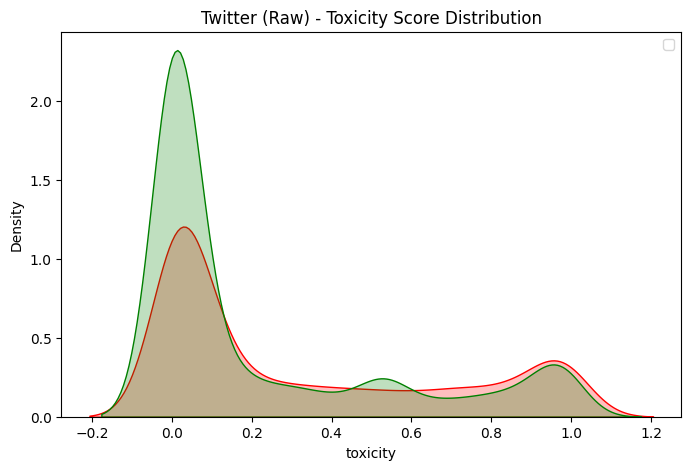

Starting toxicity prediction in batches...
  Processed batch 1/143...
  Processed batch 2/143...
  Processed batch 3/143...
  Processed batch 4/143...
  Processed batch 5/143...
  Processed batch 6/143...
  Processed batch 7/143...
  Processed batch 8/143...
  Processed batch 9/143...
  Processed batch 10/143...
  Processed batch 11/143...
  Processed batch 12/143...
  Processed batch 13/143...
  Processed batch 14/143...
  Processed batch 15/143...
  Processed batch 16/143...
  Processed batch 17/143...
  Processed batch 18/143...
  Processed batch 19/143...
  Processed batch 20/143...
  Processed batch 21/143...
  Processed batch 22/143...
  Processed batch 23/143...
  Processed batch 24/143...
  Processed batch 25/143...
  Processed batch 26/143...
  Processed batch 27/143...
  Processed batch 28/143...
  Processed batch 29/143...
  Processed batch 30/143...
  Processed batch 31/143...
  Processed batch 32/143...
  Processed batch 33/143...
  Processed batch 34/143...
  Processed ba

C:\Users\User\AppData\Local\Temp\ipykernel_12740\610311954.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


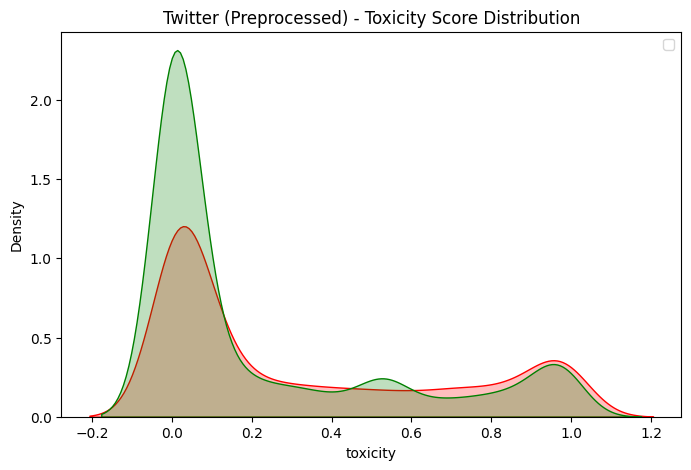

Starting toxicity prediction in batches...
  Processed batch 1/198...
  Processed batch 2/198...
  Processed batch 3/198...
  Processed batch 4/198...
  Processed batch 5/198...
  Processed batch 6/198...
  Processed batch 7/198...
  Processed batch 8/198...
  Processed batch 9/198...
  Processed batch 10/198...
  Processed batch 11/198...
  Processed batch 12/198...
  Processed batch 13/198...
  Processed batch 14/198...
  Processed batch 15/198...
  Processed batch 16/198...
  Processed batch 17/198...
  Processed batch 18/198...
  Processed batch 19/198...
  Processed batch 20/198...
  Processed batch 21/198...
  Processed batch 22/198...
  Processed batch 23/198...
  Processed batch 24/198...
  Processed batch 25/198...
  Processed batch 26/198...
  Processed batch 27/198...
  Processed batch 28/198...
  Processed batch 29/198...
  Processed batch 30/198...
  Processed batch 31/198...
  Processed batch 32/198...
  Processed batch 33/198...
  Processed batch 34/198...
  Processed ba

C:\Users\User\AppData\Local\Temp\ipykernel_12740\610311954.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


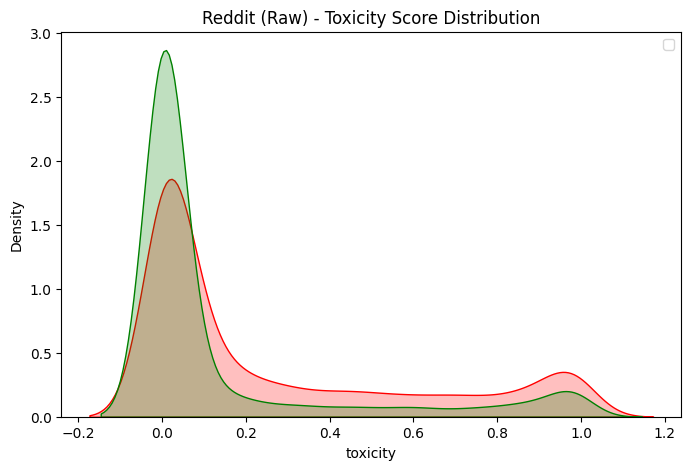

Starting toxicity prediction in batches...
  Processed batch 1/198...
  Processed batch 2/198...
  Processed batch 3/198...
  Processed batch 4/198...
  Processed batch 5/198...
  Processed batch 6/198...
  Processed batch 7/198...
  Processed batch 8/198...
  Processed batch 9/198...
  Processed batch 10/198...
  Processed batch 11/198...
  Processed batch 12/198...
  Processed batch 13/198...
  Processed batch 14/198...
  Processed batch 15/198...
  Processed batch 16/198...
  Processed batch 17/198...
  Processed batch 18/198...
  Processed batch 19/198...
  Processed batch 20/198...
  Processed batch 21/198...
  Processed batch 22/198...
  Processed batch 23/198...
  Processed batch 24/198...
  Processed batch 25/198...
  Processed batch 26/198...
  Processed batch 27/198...
  Processed batch 28/198...
  Processed batch 29/198...
  Processed batch 30/198...
  Processed batch 31/198...
  Processed batch 32/198...
  Processed batch 33/198...
  Processed batch 34/198...
  Processed ba

C:\Users\User\AppData\Local\Temp\ipykernel_12740\610311954.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


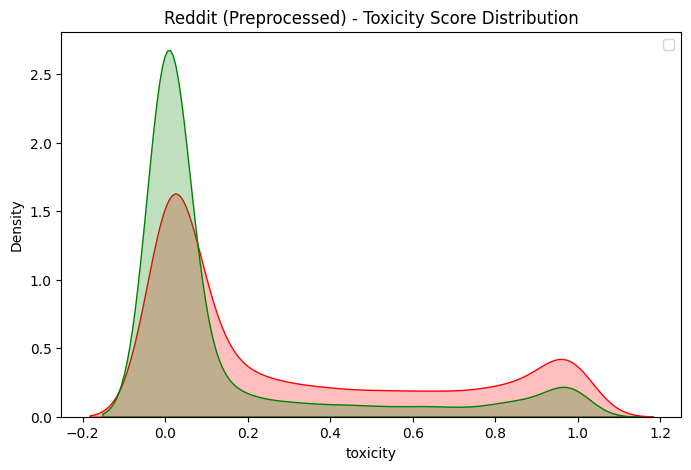

In [28]:
toxicity_analysis(df_twitter, "Twitter (Raw)")
toxicity_analysis(df_twitter_preprocessed, "Twitter (Preprocessed)")
toxicity_analysis(df_reddit, "Reddit (Raw)")
toxicity_analysis(df_reddit_preprocessed, "Reddit (Preprocessed)")

In [29]:
def profanity_analysis(df, name):
    df = df.copy()
    df['Text'] = df['Text'].fillna('')
    df['profanity'] = df['Text'].apply(lambda x: profanity.contains_profanity(x))
    profanity_count = df['profanity'].sum()
    print(f"\n{name} - Profanity Analysis:")
    print(f"Profane posts: {profanity_count} / {len(df)} ({profanity_count/len(df)*100:.2f}%)")
    for label in [0,1]:
        count = df[df['Label']==label]['profanity'].sum()
        print(f"Label {label} profane posts: {count} / {len(df[df['Label']==label])} ({count/len(df[df['Label']==label])*100:.2f}%)")

In [30]:
profanity_analysis(df_twitter, "Twitter (Raw)")
profanity_analysis(df_twitter_preprocessed, "Twitter (Preprocessed)")
profanity_analysis(df_reddit, "Reddit (Raw)")
profanity_analysis(df_reddit_preprocessed, "Reddit (Preprocessed)")


Twitter (Raw) - Profanity Analysis:
Profane posts: 2848 / 9119 (31.23%)
Label 0 profane posts: 778 / 5121 (15.19%)
Label 1 profane posts: 2070 / 3998 (51.78%)

Twitter (Preprocessed) - Profanity Analysis:
Profane posts: 2848 / 9119 (31.23%)
Label 0 profane posts: 778 / 5121 (15.19%)
Label 1 profane posts: 2070 / 3998 (51.78%)

Reddit (Raw) - Profanity Analysis:
Profane posts: 5352 / 12656 (42.29%)
Label 0 profane posts: 1346 / 6047 (22.26%)
Label 1 profane posts: 4006 / 6609 (60.61%)

Reddit (Preprocessed) - Profanity Analysis:
Profane posts: 5431 / 12656 (42.91%)
Label 0 profane posts: 1391 / 6047 (23.00%)
Label 1 profane posts: 4040 / 6609 (61.13%)


In [62]:
def pos_analysis(df, name):
    nlp_pipeline = spacy.load("en_core_web_sm", disable=["ner"])

    df = df.copy()
    df['Text'] = df['Text'].fillna('')

    # Use nlp.pipe for efficient, parallel batch processing.
    docs = nlp_pipeline.pipe(df['Text'].astype(str), n_process=-1)

    # Extract POS counts directly from the processed docs.
    pos_counts_list = [{
        'verbs': sum(1 for token in doc if token.pos_ == 'VERB'),
        'nouns': sum(1 for token in doc if token.pos_ == 'NOUN'),
        'adjs': sum(1 for token in doc if token.pos_ == 'ADJ'),
        'advs': sum(1 for token in doc if token.pos_ == 'ADV'),
        'negations': sum(1 for token in doc if token.dep_ == 'neg'),
        'past_tense': sum(1 for token in doc if token.pos_ == 'VERB' and token.tag_ in ['VBD', 'VBN'])
    } for doc in docs]

    # Join the results back to the original dataframe.
    pos_df = pd.DataFrame(pos_counts_list, index=df.index)
    df = df.join(pos_df)

    print(f"\n{name} - POS Analysis (Mean counts per post):")
    pos_stats = []
    pos_cols = ['verbs', 'nouns', 'adjs', 'advs', 'negations', 'past_tense']

    # --- Add stats for the Whole Dataset ---
    all_stats = [f"{df[col].mean():.2f}" for col in pos_cols]
    pos_stats.append(['Whole Dataset'] + all_stats + [len(df)])

    # --- Calculate stats for each class ---
    for label in [0, 1]:
        subset = df[df['Label'] == label]
        if not subset.empty:
            label_stats = [f"{subset[col].mean():.2f}" for col in pos_cols]
            pos_stats.append([f'Label {label}'] + label_stats + [len(subset)])

    print(tabulate(pos_stats, headers=['Class', 'Verbs', 'Nouns', 'Adjectives', 'Adverbs', 'Negations', 'Past Tense', 'Count'], tablefmt='fancy_grid'))

    # --- Plotting distributions (Corrected) ---
    plt.figure(figsize=(18, 4))
    plot_titles = ['Verbs', 'Nouns', 'Adjs', 'Advs', 'Negations', 'Past_Tense']
    
    for i, (col, title) in enumerate(zip(pos_cols, plot_titles)):
        plt.subplot(1, 6, i + 1)
        
        # --- FIX: Clip the view to the 90th percentile to handle outliers ---
        upper_limit = df[col].quantile(0.90)
        
        sns.kdeplot(data=df, x=col, hue='Label', palette=['green', 'red'], fill=True, clip=(0, upper_limit))
        plt.title(title)
        
    plt.suptitle(f'{name} - Part-of-Speech Distributions', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Twitter (Raw) - POS Analysis (Mean counts per post):
╒═══════════════╤═════════╤═════════╤══════════════╤═══════════╤═════════════╤══════════════╤═════════╕
│ Class         │   Verbs │   Nouns │   Adjectives │   Adverbs │   Negations │   Past Tense │   Count │
╞═══════════════╪═════════╪═════════╪══════════════╪═══════════╪═════════════╪══════════════╪═════════╡
│ Whole Dataset │   13.87 │   11.74 │         5.06 │      6.04 │        1.8  │         3.07 │    9119 │
├───────────────┼─────────┼─────────┼──────────────┼───────────┼─────────────┼──────────────┼─────────┤
│ Label 0       │    3.45 │    3    │         1.12 │      1.24 │        0.22 │         0.58 │    5121 │
├───────────────┼─────────┼─────────┼──────────────┼───────────┼─────────────┼──────────────┼─────────┤
│ Label 1       │   27.23 │   22.95 │        10.1  │     12.19 │        3.81 │         6.26 │    3998 │
╘═══════════════╧═════════╧═════════╧══════════════╧═══════════╧═════════════╧══════════════╧═════════╛


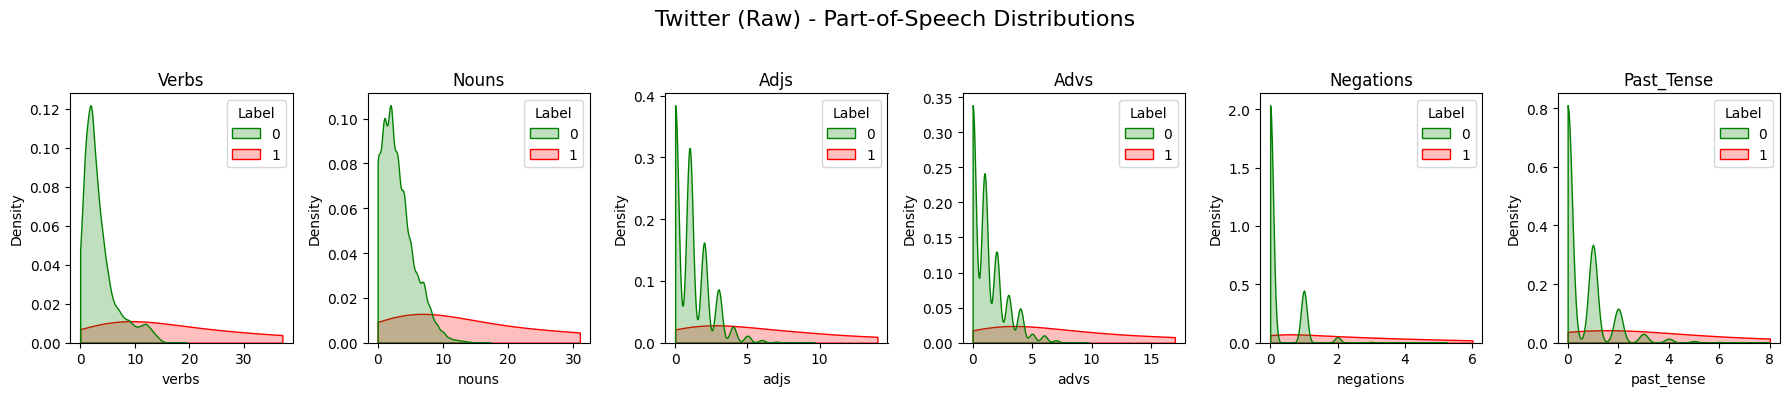


Twitter (Preprocessed) - POS Analysis (Mean counts per post):
╒═══════════════╤═════════╤═════════╤══════════════╤═══════════╤═════════════╤══════════════╤═════════╕
│ Class         │   Verbs │   Nouns │   Adjectives │   Adverbs │   Negations │   Past Tense │   Count │
╞═══════════════╪═════════╪═════════╪══════════════╪═══════════╪═════════════╪══════════════╪═════════╡
│ Whole Dataset │   13.87 │   11.74 │         5.05 │      6.04 │        1.8  │         3.07 │    9119 │
├───────────────┼─────────┼─────────┼──────────────┼───────────┼─────────────┼──────────────┼─────────┤
│ Label 0       │    3.44 │    2.99 │         1.11 │      1.24 │        0.22 │         0.59 │    5121 │
├───────────────┼─────────┼─────────┼──────────────┼───────────┼─────────────┼──────────────┼─────────┤
│ Label 1       │   27.23 │   22.95 │        10.1  │     12.19 │        3.81 │         6.26 │    3998 │
╘═══════════════╧═════════╧═════════╧══════════════╧═══════════╧═════════════╧══════════════╧═════════╛


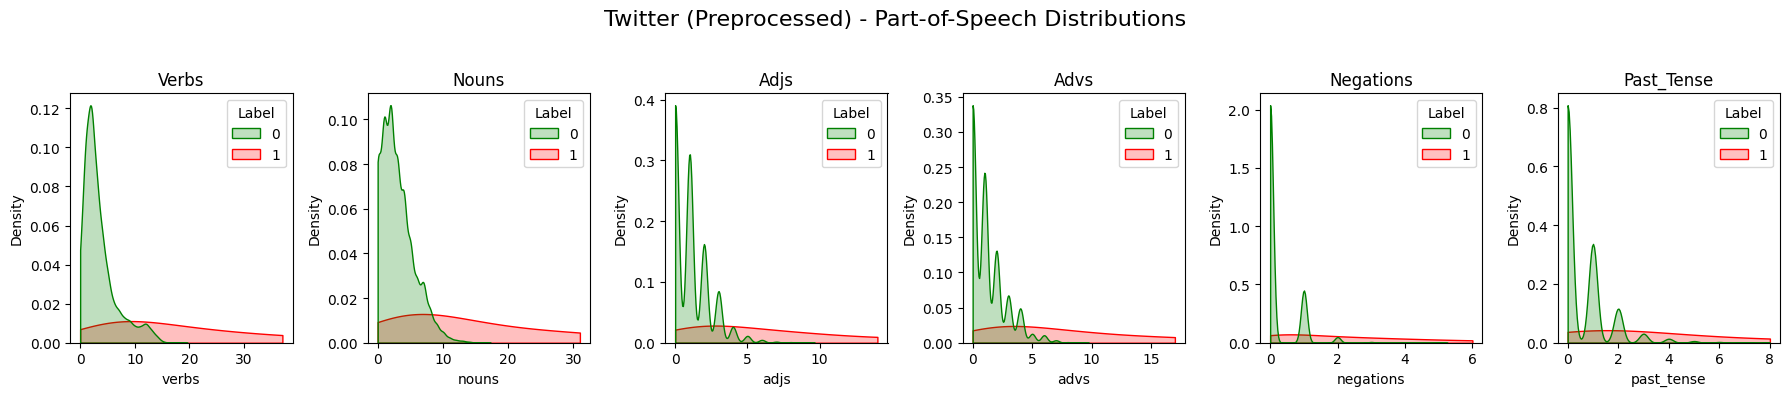


Reddit (Raw) - POS Analysis (Mean counts per post):
╒═══════════════╤═════════╤═════════╤══════════════╤═══════════╤═════════════╤══════════════╤═════════╕
│ Class         │   Verbs │   Nouns │   Adjectives │   Adverbs │   Negations │   Past Tense │   Count │
╞═══════════════╪═════════╪═════════╪══════════════╪═══════════╪═════════════╪══════════════╪═════════╡
│ Whole Dataset │   25.04 │   23.31 │        10.36 │     11.97 │        3.45 │         6.48 │   12656 │
├───────────────┼─────────┼─────────┼──────────────┼───────────┼─────────────┼──────────────┼─────────┤
│ Label 0       │   11.92 │   14.16 │         5.76 │      5.47 │        1.3  │         3.48 │    6047 │
├───────────────┼─────────┼─────────┼──────────────┼───────────┼─────────────┼──────────────┼─────────┤
│ Label 1       │   37.04 │   31.68 │        14.57 │     17.91 │        5.42 │         9.23 │    6609 │
╘═══════════════╧═════════╧═════════╧══════════════╧═══════════╧═════════════╧══════════════╧═════════╛


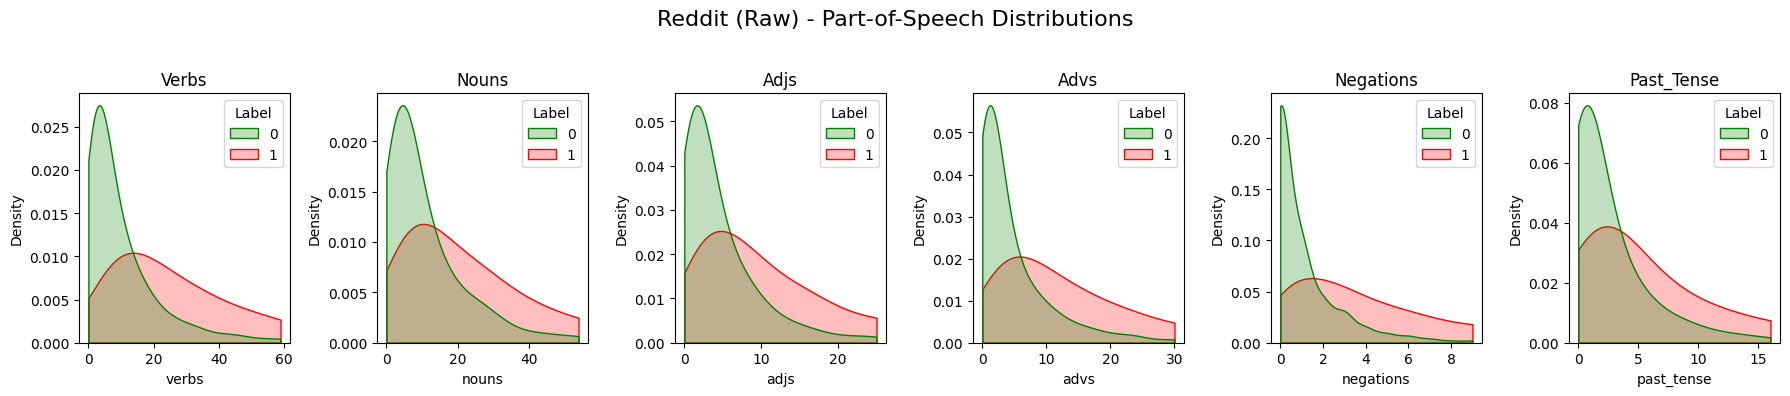


Reddit (Preprocessed) - POS Analysis (Mean counts per post):
╒═══════════════╤═════════╤═════════╤══════════════╤═══════════╤═════════════╤══════════════╤═════════╕
│ Class         │   Verbs │   Nouns │   Adjectives │   Adverbs │   Negations │   Past Tense │   Count │
╞═══════════════╪═════════╪═════════╪══════════════╪═══════════╪═════════════╪══════════════╪═════════╡
│ Whole Dataset │   27.23 │   25.3  │        10.52 │     11.86 │        1.48 │         6.73 │   12656 │
├───────────────┼─────────┼─────────┼──────────────┼───────────┼─────────────┼──────────────┼─────────┤
│ Label 0       │   12.98 │   16.23 │         6.03 │      5.46 │        0.64 │         3.64 │    6047 │
├───────────────┼─────────┼─────────┼──────────────┼───────────┼─────────────┼──────────────┼─────────┤
│ Label 1       │   40.28 │   33.59 │        14.63 │     17.72 │        2.25 │         9.57 │    6609 │
╘═══════════════╧═════════╧═════════╧══════════════╧═══════════╧═════════════╧══════════════╧═════════╛


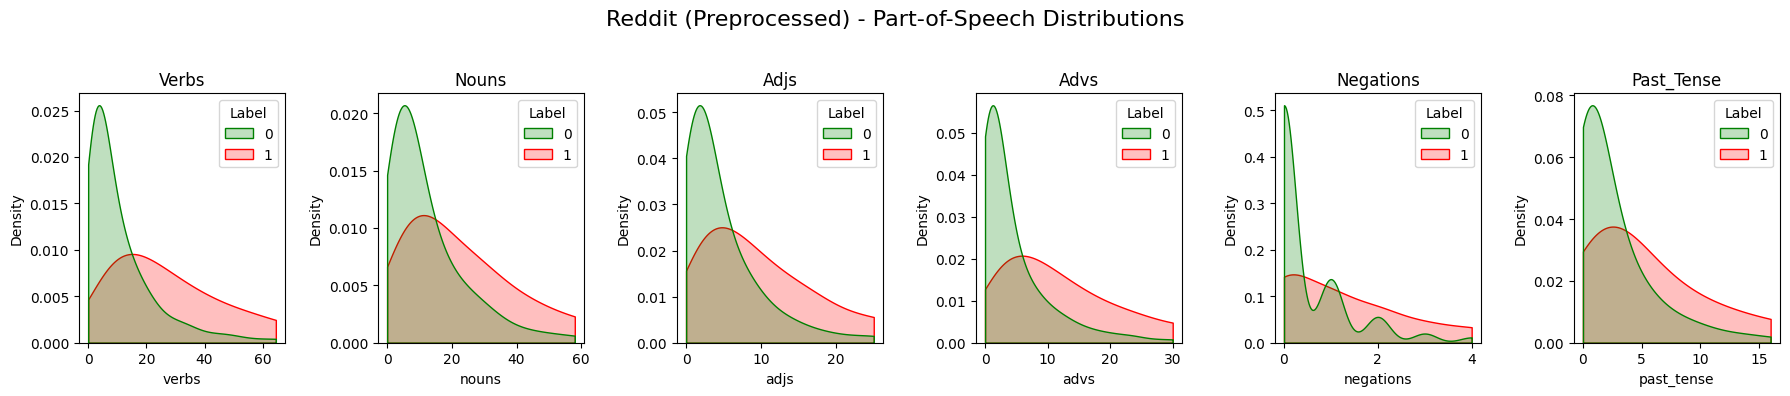

In [63]:
pos_analysis(df_twitter, "Twitter (Raw)")
pos_analysis(df_twitter_preprocessed, "Twitter (Preprocessed)")
pos_analysis(df_reddit, "Reddit (Raw)")
pos_analysis(df_reddit_preprocessed, "Reddit (Preprocessed)")